<a href="https://colab.research.google.com/github/guilhermeSuporteDev/colab/blob/main/zero_shot_house_made.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [ ]:
!pip install -r ./src/requirements.txt

# Global Definitions

In [28]:
import nltk
from nltk.corpus import wordnet
import random

nltk.download('wordnet')

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def paraphrase_sentence(sentence):
    words = sentence.split()
    paraphrased_sentence = []
    for word in words:
        synonyms = get_synonyms(word)
        if synonyms:
            paraphrased_word = random.choice(synonyms)  # Escolha um sinônimo aleatório
        else:
            paraphrased_word = word
        paraphrased_sentence.append(paraphrased_word)
    return ' '.join(paraphrased_sentence)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
import os
def get_last_trained_model_name(path, default_model):
    entries = os.listdir(path)
    directories = [entry for entry in entries if os.path.isdir(os.path.join(path, entry))]

    # Filtra e ordena os diretórios que seguem o formato "checkpoint-XX" e que XX é um número
    valid_directories = [dir for dir in directories if '-' in dir and dir.split('-')[1].isdigit()]
    valid_directories.sort(key=lambda x: int(x.split('-')[1]))

    model_name = valid_directories[-1] if valid_directories else default_model
    return model_name

In [30]:
import os
def folder_empty(folder):
    if not os.path.exists(folder):
        return True

    contents = os.listdir(folder)
    for item in contents:
        if not item.startswith('.') or not os.path.isdir(os.path.join(folder, item)):
            return False
    return True

In [31]:
# Definir códigos ANSI para cores
red_color = "\033[91m"
green_color = "\033[92m"
yellow_color = "\033[93m"
blue_color = "\033[0;34m"
reset_color = "\033[0m"

def log(text, color = blue_color):
  print(f"{color}{text}{reset_color}")

In [32]:
from IPython.display import display, Javascript

def stop_execution():
    display(Javascript('google.colab.kernel.interrupt();'))

# Definições de validação
def verificar_categorias(produtos, categorias):
    categorias_invalidas = set()
    for produto in produtos:
        if produto[1] not in categorias:
            categorias_invalidas.add(produto[1])

    if categorias_invalidas:
        print(f"Categorias inválidas encontradas: {categorias_invalidas}", red_color)
        return False;
    else:
        log("Todas as categorias são válidas.", green_color)
        return True;

def verificar_duplicatas(produtos):
    visto = set()
    duplicatas = set()
    for produto in produtos:
        if produto[0] in visto:
            duplicatas.add(produto[0])
        visto.add(produto[0])

    if duplicatas:
        log(f"Duplicatas encontradas: {duplicatas}" , red_color)
        return False;
    else:
        log("Nenhuma duplicata encontrada.", green_color)
        return True;

def verificar_itens_nao_categorizados(produtos):
    itens_nao_categorizados = [produto for produto in produtos if produto[1] == ""]

    if itens_nao_categorizados:
        log(f"Itens não categorizados encontrados: {itens_nao_categorizados}", red_color)
        return False;
    else:
        log("Todos os itens estão categorizados.", green_color)
        return True;

def validar_rotulos_de_classe(produtos, categorias):
    # Primeiro, mapear as categorias para números inteiros
    categoria_para_inteiro = {categoria: i for i, categoria in enumerate(categorias)}

    # Verificar se todos os produtos têm rótulos válidos
    rotulos_invalidos = []
    for produto in produtos:
        categoria = produto[1]
        if categoria not in categoria_para_inteiro:
            rotulos_invalidos.append((produto[0], categoria))

    # Exibir um relatório
    if rotulos_invalidos:
        log("Foram encontrados rótulos de classe inválidos:", red_color)
        for item in rotulos_invalidos:
            print(f"Produto: {item[0]}, Categoria: {item[1]}")
        return False;
    else:
        log("Todos os rótulos de classe são válidos.", green_color)
        return True;


# Build Environment

In [33]:
import os
from google.colab import userdata

def create_folder(folder_name):
  if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    log(f"Diretório '{folder_name}' criado com sucesso.", green_color)
  else:
    log(f"Diretório '{folder_name}' já existe.")

create_folder("results")
create_folder("candidates")

Diretório 'results' já existe.
Diretório 'candidates' já existe.


# Google Drive Daemon

In [34]:
import os
import shutil
from google.colab import drive

drive.mount('/content/drive')

def copy_folder_to_drive(folder_name, target_drive_folder='/content/drive/MyDrive/ML/checkpoints'):
    # Monta o Google Drive

    # Define o caminho completo da pasta de origem e destino
    source_folder = os.path.join('./results', folder_name)
    destination_folder = os.path.join(target_drive_folder, folder_name)

    # Verifica se a pasta de origem existe
    if not os.path.exists(source_folder):
        print(f"A pasta '{source_folder}' não existe.")
        return

    # Verifica se a pasta de destino já existe no Drive
    if os.path.exists(destination_folder):
        print(f"A pasta '{destination_folder}' já existe no Drive.")
        return

    # Copia a pasta
    shutil.copytree(source_folder, destination_folder)
    print(f"Pasta '{folder_name}' copiada com sucesso para '{destination_folder}'")

def fetch_checkpoint(checkpoint_folder):
  checkpoint_path = f"/content/drive/MyDrive/ML/checkpoints/{checkpoint_folder}"

  if not os.path.exists('./results'):
    os.makedirs('./results')

  destination_path = f"./results/{checkpoint_folder}"

  shutil.copytree(checkpoint_path, destination_path)

  print(f'Pasta do checkpoint copiada para: {destination_path}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Global Vars

In [58]:
# CONSTS
epochs = 15
enable_early_stop = True
models_pacience = 4
base_model = "facebook/bart-large-mnli"
results_path = "./results"
training_model = get_last_trained_model_name(results_path, base_model)
__ARGUMENT_DATA__ = True
log_evaluation = False

__ENABLE_AUTO_SAVE__ = True
__SHOULD_SAVE__ = False # Initial value
__MINIMAL_ACCURACY__ = 85.8

log(f"INICIANDO TREINAMENTO DO MODELO: {blue_color}{training_model}", green_color)

INICIANDO TREINAMENTO DO MODELO: checkpoint-20


In [36]:
def absolute_dir(model_name):
    return os.path.join('/content/results', model_name)

# Dataset

In [37]:
produtos = [
    # Higiene
    ["DESODORANTE ANTITRANSPIRANTE ACE ROLL-ON", "higiene"],
    ["SABONETE DOVE ORIGINAL", "higiene"],
    ["SHAMPOO ANTICASPA", "higiene"],
    ["PAPEL HIGIÊNICO", "higiene"],
    ["COTONETE 75 UNIDADES", "higiene"],
    ["LENÇO DE PAPEL 10 UNIDADES", "higiene"],
    ["ABSORVENTE NOTURNO 8 UNIDADES", "higiene"],
    ["ESCOVA DE DENTE MACIA", "higiene"],
    ["GEL DE BARBEAR 100G", "higiene"],
    ["ÁLCOOL GEL 70% 500ML", "higiene"],
    ["CONDICIONADOR CABELOS SECOS 200ML", "higiene"],
    ["ANTISSÉPTICO BUCAL 250ML", "higiene"],
    ["SABONETE LÍQUIDO ÍNTIMO 200ML", "higiene"],
    ["FRALDA GERIÁTRICA G 8 UNIDADES", "higiene"],
    ["FIO DENTAL 50M", "higiene"],
    ["SABONETE DE GLICERINA", "higiene"],
    ["DESODORANTE SPRAY 150ML", "higiene"],
    ["SHAMPOO ANTIQUEDA 200ML", "higiene"],
    ["CONDICIONADOR REPARADOR 200ML", "higiene"],
    ["ESPUMA DE BARBEAR 200ML", "higiene"],
    ["CREME DE BARBEAR 100G", "higiene"],
    ["CREME PARA MÃOS 75ML", "higiene"],
    ["CREME FACIAL HIDRATANTE 50G", "higiene"],
    ["PROTETOR SOLAR FPS 50 100ML", "higiene"],
    ["CREME PARA AS MÃOS 100ML", "higiene"],
    ["SHAMPOO PARA CABELOS OLEOSOS 200ML", "higiene"],
    ["CONDICIONADOR PARA CABELOS CACHEADOS 200ML", "higiene"],
    ["SABONETE ESFOLIANTE 200G", "higiene"],
    ["CREME DENTAL INFANTIL 50G", "higiene"],
    ["DESODORANTE NATURAL 50ML", "higiene"],
    ["LOÇÃO HIDRATANTE 200ML", "higiene"],
    ["ÁLCOOL EM GEL 70% 100ML", "higiene"],
    ["SHAMPOO INFANTIL 200ML", "higiene"],
    ["ESPONJA DE BANHO", "higiene"],
    ["ÁGUA OXIGENADA 100ML", "higiene"],
    ["CREME DE BARBEAR PELE SENSÍVEL 100G", "higiene"],
    ["ESPUMA DE LIMPEZA FACIAL 150ML", "higiene"],
    ["FIXADOR DE DENTADURA 40G", "higiene"],
    ["GEL ANTISSÉPTICO 70% 250ML", "higiene"],
    ["HIDRATANTE LABIAL 10G", "higiene"],
    ["LOÇÃO PÓS DEPILAÇÃO 200ML", "higiene"],
    ["MÁSCARA FACIAL DE ARGILA 100G", "higiene"],
    ["ÓLEO PARA BARBA 30ML", "higiene"],
    ["PAPEL HIGIÊNICO FOLHA DUPLA 4 ROLOS", "higiene"],
    ["PERFUME MASCULINO 50ML", "higiene"],
    ["PINÇA PARA SOBRANCELHAS", "higiene"],
    ["REMOVEDOR DE MAQUIAGEM 100ML", "higiene"],
    ["SABONETE ANTISSEPTICO 90G", "higiene"],
    ["SABONETE ÍNTIMO FEMININO 200ML", "higiene"],
    ["SHAMPOO A SECO 150ML", "higiene"],
    ["TALCO ANTISSEPTICO 100G", "higiene"],
    ["TOALHAS UMEDECIDAS 50 UNIDADES", "higiene"],
    ["ESCOVA DE LIMPEZA FACIAL", "higiene"],
    ["CREME PARA PÉS 100ML", "higiene"],
    ["DESODORANTE NATURAL EM PEDRA 60G", "higiene"],
    ["SABONETE HIDRATANTE ALOE VERA", "higiene"],
    ["SHAMPOO PARA CABELOS COLORIDOS 250ML", "higiene"],
    ["PAPEL HIGIÊNICO AROMATIZADO 4 ROLOS", "higiene"],
    ["COTONETES BIODEGRADÁVEIS 100 UNIDADES", "higiene"],
    ["LENÇO UMEDECIDO ANTIBACTERIANO 20 UNIDADES", "higiene"],
    ["ABSORVENTE DIURNO COM ABAS 10 UNIDADES", "higiene"],
    ["ESCOVA DE DENTE ELÉTRICA", "higiene"],
    ["ESPUMA DE BARBEAR HIDRATANTE 150ML", "higiene"],
    ["ÁLCOOL EM SPRAY 70% 300ML", "higiene"],
    ["CONDICIONADOR PARA CABELOS DANIFICADOS 250ML", "higiene"],
    ["ENXAGUANTE BUCAL SEM ÁLCOOL 300ML", "higiene"],
    ["GEL DE BANHO RELAXANTE 200ML", "higiene"],
    ["FRALDAS INFANTIS TAMANHO M 20 UNIDADES", "higiene"],
    ["FITA DENTAL 30M", "higiene"],
    ["SABONETE DE AVEIA", "higiene"],
    ["DESODORANTE AEROSOL 90ML", "higiene"],
    ["SHAMPOO REVITALIZANTE 250ML", "higiene"],
    ["CONDICIONADOR VOLUME CONTROL 250ML", "higiene"],
    ["GEL DE BARBEAR REFRESCANTE 150ML", "higiene"],
    ["BÁLSAMO PÓS-BARBA 75ML", "higiene"],
    ["CREME PARA CUTÍCULAS 30ML", "higiene"],
    ["SÉRUM FACIAL VITAMINA C 30ML", "higiene"],
    ["PROTETOR SOLAR FPS 30 150ML", "higiene"],
    ["LOÇÃO CORPORAL NUTRITIVA 200ML", "higiene"],
    ["SHAMPOO NEUTRO 300ML", "higiene"],
    ["CONDICIONADOR FORTIFICANTE 250ML", "higiene"],
    ["SABONETE DE CARVÃO ATIVADO 100G", "higiene"],
    ["PASTA DE DENTE NATURAL 75G", "higiene"],
    ["DESODORANTE HIPOALERGÊNICO 60ML", "higiene"],
    ["CREME CORPORAL REAFIRMANTE 200ML", "higiene"],
    ["ÁLCOOL EM GEL 70% COM ALOE VERA 200ML", "higiene"],
    ["SHAMPOO INFANTIL SEM LÁGRIMAS 250ML", "higiene"],
    ["BUCHA VEGETAL PARA BANHO", "higiene"],
    ["SOLUÇÃO PARA LENTES DE CONTATO 120ML", "higiene"],
    ["GEL DE BARBEAR PARA PELE OLEOSA 150G", "higiene"],
    ["TONICO FACIAL PELE MISTA 200ML", "higiene"],
    ["ADESIVO PARA DENTADURA 30G", "higiene"],
    ["LOÇÃO ANTISSÉPTICA 70% 150ML", "higiene"],
    ["BÁLSAMO LABIAL COM FPS 15 8G", "higiene"],
    ["GEL PÓS-BARBA CALMANTE 100ML", "higiene"],
    ["MÁSCARA FACIAL DETOX 120G", "higiene"],
    ["ÓLEO PÓS-BARBA NUTRITIVO 50ML", "higiene"],
    ["PAPEL HIGIÊNICO ECOLÓGICO 6 ROLOS", "higiene"],
    ["PERFUME FEMININO FLORAL 60ML", "higiene"],
    ["ESPÁTULA PARA CREMES FACIAIS", "higiene"],
    ["ÁGUA MICELAR DEMAQUILANTE 200ML", "higiene"],
    ["SABONETE DE TEA TREE 100G", "higiene"],

    # Laticínios
    ["LEITE INTEGRAL UHT", "laticínios"],
    ["QUEIJO MUSSARELA FATIADO", "laticínios"],
    ["CREME DE LEITE FRESCO", "laticínios"],
    ["IOGURTE NATURAL INTEGRAL", "laticínios"],
    ["QUEIJO RICOTA FRESCA", "laticínios"],
    ["LEITE FERMENTADO 100G", "laticínios"],
    ["YOGURTE GREGO 100G", "laticínios"],
    ["COALHADA SECA 200G", "laticínios"],
    ["LEITE EM PÓ INTEGRAL 400G", "laticínios"],
    ["QUEIJO GOUDA 100G", "laticínios"],
    ["CREME DE RICOTA 150G", "laticínios"],
    ["LEITE CONDENSADO 395G", "laticínios"],
    ["DOCE DE LEITE 400G", "laticínios"],
    ["QUEIJO PROVOLONE 100G", "laticínios"],
    ["QUEIJO BRIE 125G", "laticínios"],
    ["LEITE DE CABRA 1L", "laticínios"],
    ["QUEIJO COTTAGE 200G", "laticínios"],
    ["QUEIJO PARMESÃO RALADO 100G", "laticínios"],
    ["IOGURTE DE COCO 170G", "laticínios"],
    ["SORVETE DE IOGURTE 1L", "laticínios"],
    ["LEITE SEM LACTOSE 1L", "laticínios"],
    ["QUEIJO FETA 200G", "laticínios"],
    ["MANTEIGA GHEE 200G", "laticínios"],
    ["QUEIJO CAMEMBERT 125G", "laticínios"],
    ["LEITE VEGETAL DE AVEIA 1L", "laticínios"],
    ["QUEIJO ROQUEFORT 100G", "laticínios"],
    ["LEITE FLAN 200G", "laticínios"],
    ["YOGURTE DE AMORA 170G", "laticínios"],
    ["CREME DE LEITE NATA 300G", "laticínios"],
    ["LEITE DE ARROZ 1L", "laticínios"],
    ["QUEIJO EDAM 150G", "laticínios"],
    ["LEITE DE COCO PARA BEBER 1L", "laticínios"],
    ["IOGURTE DE BANANA 170G", "laticínios"],
    ["LEITE DE SOJA 1L", "laticínios"],
    ["QUEIJO QUARK 150G", "laticínios"],
    ["QUEIJO MINAS CURADO 200G", "laticínios"],
    ["LEITE DE AMÊNDOA 1L", "laticínios"],
    ["QUEIJO PROVOLONE 200G", "laticínios"],
    ["LEITE DE AVELÃ 1L", "laticínios"],
    ["LEITE DE MACADÂMIA 1L", "laticínios"],
    ["LEITE DESNATADO 1L", "laticínios"],
    ["SORVETE DE FLOCOS 2L", "laticínios"],
    ["IOGURTE DE FRAMBOESA 170G", "laticínios"],
    ["QUEIJO MINAS FRESCAL LIGHT 200G", "laticínios"],
    ["CREME DE RICOTA LIGHT 150G", "laticínios"],
    ["IOGURTE DE MEL 170G", "laticínios"],
    ["QUEIJO CANASTRA 200G", "laticínios"],
    ["IOGURTE DE MANGA 170G", "laticínios"],
    ["LEITE CONDENSADO DIET 395G", "laticínios"],
    ["IOGURTE COM PEDAÇOS DE FRUTA 170G", "laticínios"],
    ["IOGURTE GREGO LIGHT 100G", "laticínios"],
    ["QUEIJO PRATO LIGHT 150G", "laticínios"],
    ["SORVETE DE ABACAXI 1L", "laticínios"],
    ["LEITE VEGETAL DE NOZ PECÃ 1L", "laticínios"],
    ["LEITE VEGETAL DE CASTANHA DE CAJU 1L", "laticínios"],

    ['LEITE INTEGRAL QUALQUER', 'laticínios'],
    ['LEITE EM PO NINHO INSTANTANEO LV 400 PG 380 GR', 'laticínios'],
    ['BEB LACTEA PIRACANJUBA 200 ML AMEIXA', 'laticínios'],
    ['CR LEITE PIRACANJUBA 200 GR', 'laticínios'],
    ['CR LEITE ITALAC 200 GR', 'laticínios'],
    ['BEB LACTEA PIRACANJUBA 200 ML AM', 'laticínios'],
    ['LEITE LV PIRACANJUBA 1 LT ZERO LACT SEMI DESNATADO', 'laticínios'],
    ['CR LEITE NESTLE 200 GR TP TRAD', 'laticínios'],
    ['LEITE PO PIRACANJUBA 400 GR INTEGRAL', 'laticínios'],
    ['BEB LACTEA PIRACANJUBA ZERO 200 ML MAMAO/MACA', 'laticínios'],
    ['LEITE PO PIRACANJUBA 800 GR INT INSTANTANEO', 'laticínios'],
    ['IOG NATURAL VIGOR 150 GR AMEIXA', 'laticínios'],
    ['IOG NATURAL VIGOR 150 GR MAMAO', 'laticínios'],
    ['LEITE PO PIRACANJUBA 800 GR INTEGRAL', 'laticínios'],
    ['QJ MUSSARELA LIGHT TIROLEZ 150 GR', 'laticínios'],
    ['BEB LACTEA PIRACANJUBA ZERO 200 ML FRUTAS VERM', 'laticínios'],
    ['MARG DORIANA CREMOSA 500 GR COM SAL', 'laticínios'],
    ['QJ MUSSARELA PC KG', 'laticínios'],
    ['QJ MUSSARELA PD KG', 'laticínios'],
    ['QJ MUSSARELA FT KG', 'laticínios'],
    ['RICOTA FRESCA TIROLEZ KG', 'laticínios'],
    ['CR RICOTA TIROLEZ 200 GR', 'laticínios'],
    ['PETIT DANONINHO 320 GR MULTI', 'laticínios'],
    ['PETIT DANONINHO 320 GR MORANGO', 'laticínios'],
    ['QJ MUSSARELA BDJ KG', 'laticínios'],
    ['CR RICOTA TIROLEZ 200 GR LIGHT', 'laticínios'],
    ['LEITE LV PIRACANJUBA 1 LT C/TAMPA INTEGRAL', 'laticínios'],
    ['LEITE LV PIRACANJUBA 1 LT C/TAMPA SEMI DESN', 'laticínios'],
    ['LEITE LV PIRACANJUBA 1 LT C/TAMPA DESNATADO', 'laticínios'],
    ['QUEIJO PRATO SADIA SOLTISSIMO 200GR.', 'laticínios'],
    ['LEITE FERMENTADO ACTIVIA LIQUIDO MORANGO 1.000GR', 'laticínios'],
    ['QUEIJO MINAS TIROLEZ FRESCAL  KG.', 'laticínios'],
    ['QUEIJO MINAS ATILATTE FRESCAL KG.', 'laticínios'],
    ['QUEIJO PARMESAO VIGOR RALADO 50GR.', 'laticínios'],
    ['QUEIJO GORGONZOLA TIROLEZ A CADA 100G', 'laticínios'],
    ['QUEIJO GOUDA TIROLEZ A CADA 100G.', 'laticínios'],
    ['LEITE FERMENTADO BATAVO 850GR.', 'laticínios'],
    ['MANTEIGA BATAVO EXTRA  TABLETE 200GR.', 'laticínios'],
    ['LEITE RICO PASTEURIZADO TIPO A SACO 1LT.', 'laticínios'],

    # Doces
    ['BISCOITO RECHEADO CHOCOLATE', 'doces'],
    ['CHOCOLATE AO LEITE 100G', 'doces'],
    ['GELEIA DE MORANGO DIET', 'doces'],
    ['BALA DE COCO 100G', 'doces'],
    ['PIRULITO SABOR FRUTAS', 'doces'],
    ['BARRA DE CEREAL CHOCOLATE', 'doces'],
    ['GOMA DE MASCAR MENTA', 'doces'],
    ['BOMBOM SORTIDO 200G', 'doces'],
    ['PUDIM DE CHOCOLATE', 'doces'],
    ['WAFER DE MORANGO', 'doces'],
    ['GELATINA DE UVA', 'doces'],
    ['BRIGADEIRO POTE 200G', 'doces'],
    ['PÉ DE MOLEQUE 100G', 'doces'],
    ['PAÇOCA ROLHA', 'doces'],
    ['QUINDIM INDIVIDUAL', 'doces'],
    ['BARRA DE CHOCOLATE AMARGO 100G', 'doces'],
    ['SUSPIRO 100G', 'doces'],
    ['MILKSHAKE EM PÓ 200G', 'doces'],
    ['CHOCOTONE 500G', 'doces'],
    ['GOIABADA CASCÃO 300G', 'doces'],
    ['TORRONE 100G', 'doces'],
    ['BANANA PASSA 100G', 'doces'],
    ['BARRA DE CEREAL DE FRUTAS', 'doces'],
    ['BOLO DE CHOCOLATE 100G', 'doces'],
    ['CHURROS CONGELADO', 'doces'],
    ['DOCE DE COCO 200G', 'doces'],
    ['GELATINA DE LIMÃO', 'doces'],
    ['MARSHMALLOW 100G', 'doces'],
    ['PASTEL DE NATA', 'doces'],
    ['TORTA DE LIMÃO 300G', 'doces'],
    ['TRUFA DE CHOCOLATE 100G', 'doces'],
    ['BISCOITO DE MAIZENA 150G', 'doces'],
    ['BARRA DE CHOCOLATE COM AMENDOAS 100G', 'doces'],
    ['BISCOITO WAFFLE 100G', 'doces'],
    ['BALAS DE GENGIBRE 100G', 'doces'],
    ['BALAS DE MENTA 100G', 'doces'],
    ['BOMBONS FINOS SORTIDOS 200G', 'doces'],
    ['CHOCOLATE QUENTE EM PÓ 200G', 'doces'],
    ['DOCE DE ABÓBORA 300G', 'doces'],
    ['DOCE DE BANANA 300G', 'doces'],
    ['GELEIA DE MARMELADA 200G', 'doces'],
    ['CHOCOLATE AMARGO 85% CACAU 100G', 'doces'],
    ['PÉ DE MOLEQUE 200G', 'doces'],
    ['BARRA DE CEREAL DE MEL E NUTS', 'doces'],
    ['BISCOITO DE GENGIBRE 150G', 'doces'],
    ['TORRONE DE AMENDOIM 100G', 'doces'],
    ['BOMBOM DE LICOR 200G', 'doces'],
    ['PASTILHAS DE CHOCOLATE 100G', 'doces'],
    ['BALA DE CARAMELO 100G', 'doces'],
    ['BISCOITO DE CHOCOLATE BRANCO 150G', 'doces'],
    ['COCADA BRANCA 200G', 'doces'],
    ['CROISSANT DE CHOCOLATE', 'doces'],
    ['MINI SONHO 100G', 'doces'],
    ['BAGEL 100G', 'doces'],
    ['BISCOITO AMANTEIGADO 100G', 'doces'],
    ['BROWNIE 100G', 'doces'],
    ['CROISSANT DE QUEIJO 100G', 'doces'],
    ['BOLACHA DE CHOCOLATE RECHEADA 150G', 'doces'],
    ['CROISSANT INTEGRAL 100G', 'doces'],
    ['MUFFIN DE BAUNILHA 100G', 'doces'],
    ['BISCOITO AMANTEIGADO DE COCO 100G', 'doces'],
    ['BISCOITO DE CHAMPAGNE 150G', 'doces'],
    ['BOLINHO DE CHUVA PRONTO', 'doces'],
    ["BISCOITO ÁGUA E SAL INTEGRAL 200G", "doces"],
    ['BISCOITO DE POLVILHO 100G', 'doces'],
    ['BISCOITO DE NATA 100G', 'doces'],
    ['BISCOITO DE POLVILHO AZEDO 100G', 'doces'],
    ['BISCOITO DE LEITE 200G', 'doces'],
    ['BISCOITO DE AVENA 100G', 'doces'],
    ['BISCOITO DE GENGIBRE 100G', 'doces'],
    ['BISCOITO SALGADO 200G', 'doces'],
    ['BISCOITO DE ARROZ 100G', 'doces'],

    # Carnes
    ["PEITO DE FRANGO CONGELADO", "carnes"],
    ["FILE DE TILAPIA CONGELADO", "carnes"],
    ["ALCATRA COMPLETA KG", "carnes"],
    ["COSTELA SUINA CONGELADA", "carnes"],
    ["LINGUIÇA TOSCANA", "carnes"],
    ["COSTELA BOVINA KG", "carnes"],
    ["FRANGO A PASSARINHO KG", "carnes"],
    ["CARNE SUÍNA MOÍDA KG", "carnes"],
    ["LINGUIÇA CALABRESA 200G", "carnes"],
    ["HAMBÚRGUER SUÍNO 4 UNIDADES", "carnes"],
    ["ALMONDEGA BOVINA 300G", "carnes"],
    ["BISTECA SUÍNA KG", "carnes"],
    ["COXA DE FRANGO KG", "carnes"],
    ["SALSICHA FRANGO 500G", "carnes"],
    ["BACON EM FATIAS 200G", "carnes"],
    ["COSTELA DE CORDEIRO KG", "carnes"],
    ["PERNIL SUÍNO KG", "carnes"],
    ["RABADA BOVINA KG", "carnes"],
    ["CARNE DE JAVALI KG", "carnes"],
    ["FÍGADO BOVINO KG", "carnes"],
    ["CARNE DE PATO KG", "carnes"],
    ["MIOLO DE ALCATRA KG", "carnes"],
    ["CORDEIRO MOÍDO KG", "carnes"],
    ["FILE MIGNON SUÍNO KG", "carnes"],
    ["CARNE DE BÚFALO KG", "carnes"],
    ["FRANGO ORGÂNICO KG", "carnes"],
    ["CARNE DE CORDEIRO KG", "carnes"],
    ["COSTELA DE PORCO KG", "carnes"],
    ["COSTELA DE BOI KG", "carnes"],
    ["CARNE DE COELHO KG", "carnes"],
    ["PERDIZ KG", "carnes"],
    ["LINGUIÇA DE PERNIL 500G", "carnes"],
    ["COSTELA DE VACA KG", "carnes"],
    ["FRANGO CAIPIRA KG", "carnes"],
    ["CARNE DE PORCO ALCATRA KG", "carnes"],
    ["BIFE DE CHORIZO KG", "carnes"],
    ["PEITO DE PERU KG", "carnes"],
    ["CARNE DE VEADO KG", "carnes"],
    ["CARNE DE CABRA KG", "carnes"],
    ["PATO INTEIRO KG", "carnes"],
    ["PERU INTEIRO KG", "carnes"],
    ["COXA DE FRANGO COM PELE KG", "carnes"],
    ["SALSICHA DE PERU 500G", "carnes"],
    ["CARNE DE FÍGADO BOVINO KG", "carnes"],
    ["MÚSCULO BOVINO KG", "carnes"],
    ["CARNE MOÍDA DE PERU 500G", "carnes"],
    ["BIFE DE FIGADO KG", "carnes"],
    ["CARNE DE JAVALI SELVAGEM KG", "carnes"],
    ["FRANGO ORGÂNICO DESFIADO 500G", "carnes"],
    ["PEITO DE PATO KG", "carnes"],
    ["COSTELA SUÍNA DEFUMADA KG", "carnes"],
    ["CARNE SECA DESFIADA 500G", "carnes"],
    ["MAMINHA BOVINA KG", "carnes"],
    ["PICANHA SUÍNA KG", "carnes"],
    ["FRANGO INTEIRO CONGELADO", "carnes"],
    ["LINGUIÇA DE FRANGO 300G", "carnes"],
    ["CONTRA FILÉ BOVINO KG", "carnes"],
    ["TRUTA FILE 200G", "carnes"],
    ["ASA DE FRANGO KG", "carnes"],
    ["CARNE MOÍDA DE CORDEIRO 500G", "carnes"],
    ["LINGUIÇA DE PIMENTA 250G", "carnes"],
    ["HAMBÚRGUER DE FRANGO 4 UNIDADES", "carnes"],
    ["BOLINHO DE CARNE 400G", "carnes"],
    ["LOMBO SUÍNO KG", "carnes"],
    ["SOBRECOXA DE FRANGO KG", "carnes"],
    ["SALSICHA BOVINA 500G", "carnes"],
    ["BACON EM CUBOS 300G", "carnes"],
    ["COSTELA DE VITELA KG", "carnes"],
    ["LOMBO CANADENSE KG", "carnes"],
    ["CUPIM BOVINO KG", "carnes"],
    ["CARNE DE BISÃO KG", "carnes"],
    ["CORACAO DE FRANGO KG", "carnes"],
    ["COXA DE PATO KG", "carnes"],
    ["FRALDINHA BOVINA KG", "carnes"],
    ["CORDEIRO ASSADO KG", "carnes"],
    ["COSTELETA DE PORCO KG", "carnes"],
    ["CARNE DE CAVALO KG", "carnes"],
    ["FRANGO SEM HORMÔNIOS KG", "carnes"],
    ["PERNIL DE CORDEIRO KG", "carnes"],
    ["COSTELINHA DE PORCO DEFUMADA KG", "carnes"],
    ["PEIXE ROBALO KG", "carnes"],
    ["PONTA DE AGULHA KG", "carnes"],
    ["CARNE DE AVESTRUZ KG", "carnes"],
    ["CABRITO KG", "carnes"],
    ["LINGUIÇA DE VITELA 500G", "carnes"],
    ["COSTELA DE BÚFALO KG", "carnes"],
    ["FRANGO DESOSSADO KG", "carnes"],
    ["LÍNGUA SUÍNA KG", "carnes"],
    ["BIFE ANCHO KG", "carnes"],
    ["PEITO DE GANSO KG", "carnes"],
    ["CARNE DE CANGURU KG", "carnes"],
    ["FILÉ DE CABRITO KG", "carnes"],
    ["PATO DESOSSADO KG", "carnes"],
    ["COXA DE PERU KG", "carnes"],
    ["SOBRECOXA DE FRANGO DESOSSADA KG", "carnes"],
    ["SALSICHA DE CARNEIRO 500G", "carnes"],
    ["FÍGADO DE FRANGO KG", "carnes"],
    ["PÁ DE BOI KG", "carnes"],
    ["CARNE MOÍDA DE AVESTRUZ 500G", "carnes"],
    ["BIFE DE RIM KG", "carnes"],
    ["CARNE DE PORCO SELVAGEM KG", "carnes"],
    ["FRANGO DEFUMADO DESFIADO 500G", "carnes"],
    ["PEITO DE CODORNA KG", "carnes"],
    ["COSTELA BOVINA DEFUMADA KG", "carnes"],
    ["CARNE DE SOL DESFIADA 500G", "carnes"],
    ['MUSCULO BOVINO', 'carnes'],
    ['COXAO MOLE PC KG', 'carnes'],
    ['PICANHA FATIADA VACUO KG', 'carnes'],
    ['PERNIL SUI - PEDACO C/ BANDEJ KG.', 'carnes'],
    ['PALETA SUINA C/OSSO - FATIADA BANDEJA KG.', 'carnes'],
    ['LOMBO SUINO - PEDACO BANDEJA KG', 'carnes'],
    ['FILE COXA C/SOBRECOXA DE FRANGO - RESFRIADO PACOTE KG', 'carnes'],
    ['PICANHA BOVINA FRIBOI FATIADA BANDEJA KG.', 'carnes'],
    ['COXAO DURO BOVINO - KG.', 'carnes'],
    ['BISTECA DO LOMBO - FRESCA KG.', 'carnes'],
    ['COSTELINHA SUINA - KG.', 'carnes'],
    ['COSTELA BOVINA - MINGA KG.', 'carnes'],
    ['MEIO DA ASA DE FRANGO - RESFRIADO BANDEJA KG', 'carnes'],

    # Grãos e Cereais
    ["CEREAL SUCRILHOS KELLOGS 700G", "grãos e cereais"],
    ["FARINHA DE TRIGO INTEGRAL", "grãos e cereais"],
    ["AVEIA EM FLOCOS 200G", "grãos e cereais"],
    ["SEMENTE DE CHIA 100G", "grãos e cereais"],
    ["FARINHA DE AVEIA 500G", "grãos e cereais"],
    ["FAROFA PRONTA 250G", "grãos e cereais"],
    ["TRIGO PARA QUIBE 500G", "grãos e cereais"],
    ["FARINHA DE MANDIOCA 500G", "grãos e cereais"],
    ["FLOCOS DE MILHO SEM AÇÚCAR", "grãos e cereais"],
    ["LENTILHA 500G", "grãos e cereais"],
    ["ERVILHA SECA 500G", "grãos e cereais"],
    ["SEMENTE DE LINHAÇA 200G", "grãos e cereais"],
    ["FARINHA DE CENTEIO 500G", "grãos e cereais"],
    ["FARINHA DE COCO 200G", "grãos e cereais"],
    ["MIX DE NUTS 100G", "grãos e cereais"],
    ["FARINHA DE QUINOA 500G", "grãos e cereais"],
    ["TRIGO SARRACENO 500G", "grãos e cereais"],
    ["CEVADA EM GRÃO 500G", "grãos e cereais"],
    ["AMÊNDOAS 100G", "grãos e cereais"],
    ["CASTANHA-DO-PARÁ 100G", "grãos e cereais"],
    ["FARINHA DE MILHO 1KG", "grãos e cereais"],
    ["CEVADA 500G", "grãos e cereais"],
    ["FARINHA DE CHIA 200G", "grãos e cereais"],
    ["TRIGO PARA KIBE 500G", "grãos e cereais"],
    ["FARINHA DE MANDIOCA 1KG", "grãos e cereais"],
    ["FARINHA DE GRÃO DE BICO 500G", "grãos e cereais"],
    ["MILHO DE PIPOCA 500G", "grãos e cereais"],
    ["AVEIA EM FLOCOS 500G", "grãos e cereais"],
    ["FARINHA DE TAPIOCA 500G", "grãos e cereais"],
    ["SEMENTE DE GIRASSOL 200G", "grãos e cereais"],
    ["FARINHA DE ARROZ INTEGRAL 1KG", "grãos e cereais"],
    ["FARINHA DE SORGO 500G", "grãos e cereais"],
    ["FARINHA DE MILHO AMARELO 1KG", "grãos e cereais"],
    ["FARINHA DE BATATA DOCE 500G", "grãos e cereais"],
    ["AVEIA EM FLOCOS FINOS 500G", "grãos e cereais"],
    ["FARINHA DE TRIGO PARA PÃO 1KG", "grãos e cereais"],
    ["FARINHA DE TRIGO SARRACENO 500G", "grãos e cereais"],
    ["FARINHA DE LINHAÇA DOURADA 500G", "grãos e cereais"],
    ["FARINHA DE BANANA VERDE ORGÂNICA 200G", "grãos e cereais"],
    ["TRIGO EM GRÃO 1KG", "grãos e cereais"],
    ["MILHO VERDE EM CONSERVA", "grãos e cereais"],
    ["ERVILHAS EM CONSERVA", "grãos e cereais"],
    ["FEIJÃO FRADINHO 1KG", "grãos e cereais"],
    ["FEIJÃO PRETO ORGÂNICO 1KG", "grãos e cereais"],
    ["MUESLI INTEGRAL 500G", "grãos e cereais"],
    ["FARINHA DE AMÊNDOA 400G", "grãos e cereais"],
    ["QUINOA VERMELHA EM GRÃO 500G", "grãos e cereais"],
    ["SEMENTE DE GIRASSOL TORRADA 150G", "grãos e cereais"],
    ["FARINHA DE CEVADA 500G", "grãos e cereais"],
    ["FARINHA DE MILHETO 500G", "grãos e cereais"],
    ["CEVADA PEROLADA 500G", "grãos e cereais"],
    ["FARINHA DE QUINOA VERMELHA 400G", "grãos e cereais"],
    ["MILHO PARA CANJICA 500G", "grãos e cereais"],
    ["GRÃO DE BICO TORRADO 300G", "grãos e cereais"],
    ["FEIJÃO AZUKI 500G", "grãos e cereais"],
    ["SEMENTE DE ABÓBORA TORRADA 150G", "grãos e cereais"],
    ["FARINHA DE ARROZ 1KG", "grãos e cereais"],
    ["FARINHA DE BANANA 500G", "grãos e cereais"],
    ["MIX DE CEREAIS 200G", "grãos e cereais"],
    ["FARINHA DE QUINOA BRANCA 500G", "grãos e cereais"],
    ["TRIGO EM BERRIES 500G", "grãos e cereais"],
    ["GRÃO DE BICO EM PÓ 500G", "grãos e cereais"],
    ["SEMENTE DE GIRAÇOL INTEGRAL 200G", "grãos e cereais"],
    ["NOZES 100G", "grãos e cereais"],
    ["CASTANHA DE CAJU 100G", "grãos e cereais"],
    ["FARINHA DE ROSCA 500G", "grãos e cereais"],
    ["FARINHA DE CENTEIO INTEGRAL 500G", "grãos e cereais"],
    ["FARINHA DE CHIA PRETA 200G", "grãos e cereais"],
    ["TRIGO EM GRÃO PARA PILOF 500G", "grãos e cereais"],
    ["FARINHA DE MANDIOCA TORRADA 1KG", "grãos e cereais"],
    ["FARINHA DE GRÃO DE BICO ORGÂNICA 500G", "grãos e cereais"],
    ["MILHO PARA MOINHO 500G", "grãos e cereais"],
    ["GRANOLA INTEGRAL 500G", "grãos e cereais"],
    ["FARINHA DE TAPIOCA GRANULADA 500G", "grãos e cereais"],
    ["SEMENTE DE MELÃO SECAS 200G", "grãos e cereais"],
    ["FARINHA DE ARROZ JAPONÊS 1KG", "grãos e cereais"],
    ["FARINHA DE TRIGO ESPECIAL 500G", "grãos e cereais"],
    ["POLVILHO AZEDO 1KG", "grãos e cereais"],
    ["FARINHA DE BATATA 500G", "grãos e cereais"],
    ["FLOCOS DE AVEIA GROSSOS 500G", "grãos e cereais"],
    ["FARINHA DE TRIGO INTEGRAL ORGÂNICA 1KG", "grãos e cereais"],
    ["AMARANTO EM FLOCOS 500G", "grãos e cereais"],
    ["FARINHA DE ARROZ PRETO 500G", "grãos e cereais"],
    ["FARINHA DE GRÃO DE BICO FINA 500G", "grãos e cereais"],

    # Não Perecível
    ["ARROZ JASMIM 500G", "não perecível"],
    ["ARROZ PARBOILIZADO 1KG", "não perecível"],
    ["ARROZ BASMATI 1KG", "não perecível"],
    ["ARROZ INTEGRAL PRETO 1KG", "não perecível"],
    ["ARROZ SELVAGEM 500G", "não perecível"],
    ["ARROZ CARIOCA 1KG", "não perecível"],
    ["ARROZ AGULHINHA TIPO 1", "não perecível"],
    ["ARROZ INTEGRAL 1KG", "não perecível"],
    ["AZEITE DE OLIVA EXTRA VIRGEM", "não perecível"],
    ["MACARRÃO COM OVOS", "não perecível"],
    ["BATATA PALHA", "não perecível"],
    ["PIMENTA DO REINO MOÍDA", "não perecível"],
    ["CÁPSULAS DE CAFÉ", "não perecível"],
    ["FAROFA PRONTA TRADICIONAL", "não perecível"],
    ["MISTURA PARA BOLO DE CHOCOLATE", "não perecível"],
    ["SARDINHA EM LATA", "não perecível"],
    ["MOLHO DE TOMATE 340G", "não perecível"],
    ["ATUM RALADO EM ÓLEO", "não perecível"],
    ["SAL REFINADO 1KG", "não perecível"],
    ["EXTRATO DE TOMATE 140G", "não perecível"],
    ["ERVILHA EM CONSERVA", "não perecível"],
    ["PALMITO EM CONSERVA", "não perecível"],
    ["AZEITONA PRETA 100G", "não perecível"],
    ["MOLHO SHOYU 150ML", "não perecível"],
    ["EXTRATO DE SOJA EM PÓ 200G", "não perecível"],
    ["MOLHO BARBECUE 200ML", "não perecível"],
    ["MOLHO INGLÊS 150ML", "não perecível"],
    ["VINAGRE DE MAÇÃ 500ML", "não perecível"],
    ["KETCHUP 340G", "não perecível"],
    ["MOSTARDA 200G", "não perecível"],
    ["TEMPERO PRONTO EM PÓ", "não perecível"],
    ["CALDO DE GALINHA EM CUBOS", "não perecível"],
    ["MOLHO DE PIMENTA 150ML", "não perecível"],
    ["MOLHO TÁRTARO 200ML", "não perecível"],
    ["VINAGRE DE VINHO 500ML", "não perecível"],
    ["MOLHO DE MOSTARDA 200ML", "não perecível"],
    ["MOLHO DE ALHO 150ML", "não perecível"],
    ["EXTRATO DE TOMATE 350G", "não perecível"],
    ["CONSERVA DE MILHO 200G", "não perecível"],
    ["AZEITONAS VERDES 200G", "não perecível"],
    ["PALMITO EM CONSERVA 300G", "não perecível"],
    ["PIMENTA BIQUINHO EM CONSERVA 100G", "não perecível"],
    ["MOLHO DE CHAMPIGNON 200G", "não perecível"],
    ["GRÃO DE BICO EM LATA", "não perecível"],
    ["MOLHO DE GENGIBRE 200ML", "não perecível"],
    ["VINAGRETE 300G", "não perecível"],
    ["MASSA DE PIZZA PRONTA", "não perecível"],
    ["CALDO DE LEGUMES EM PÓ", "não perecível"],
    ["SAL GROSSO IODADO 1KG", "não perecível"],
    ["ARROZ ARBÓREO 1KG", "não perecível"],
    ["PIMENTA CALABRESA EM FLOCOS", "não perecível"],
    ["TEMPERO PARA CARNES", "não perecível"],
    ["ALHO EM PÓ 100G", "não perecível"],
    ["CREME DE ASPARGOS EM PÓ", "não perecível"],
    ["SOPA DE ERVILHA DESIDRATADA", "não perecível"],
    ["LEITE EM PÓ DESNATADO 200G", "não perecível"],
    ["SAL ROSA DO HIMALAIA 500G", "não perecível"],
    ["MISTURA PARA BOLO DE LARANJA", "não perecível"],
    ["MOLHO PESTO 180G", "não perecível"],
    ["PURÊ DE BATATA EM FLOCOS", "não perecível"],
    ["PÃO SÍRIO INTEGRAL", "não perecível"],
    ["AZEITE DE ABACATE VIRGEM", "não perecível"],
    ["MACARRÃO INTEGRAL", "não perecível"],
    ["BATATA FRITA CROCANTE", "não perecível"],
    ["PIMENTA CAYENNE EM PÓ", "não perecível"],
    ["CÁPSULAS DE CHÁ VERDE", "não perecível"],
    ["FAROFA PRONTA COM BACON", "não perecível"],
    ["MISTURA PARA BOLO DE CENOURA", "não perecível"],
    ["CAVALA EM LATA", "não perecível"],
    ["MOLHO DE PIZZA 300G", "não perecível"],
    ["ATUM EM ÁGUA", "não perecível"],
    ["SAL MARINHO 1KG", "não perecível"],
    ["POLPA DE TOMATE 150G", "não perecível"],
    ["GRÃO DE BICO EM CONSERVA", "não perecível"],
    ["CORACÃO DE ALCACHOFRA EM CONSERVA", "não perecível"],
    ["AZEITONA VERDE 150G", "não perecível"],
    ["MOLHO HOISIN 150ML", "não perecível"],
    ["PROTEÍNA DE ERVILHA EM PÓ 200G", "não perecível"],
    ["MOLHO BARBECUE DEFUMADO 220ML", "não perecível"],
    ["MOLHO HP 150ML", "não perecível"],
    ["VINAGRE DE FRAMBOESA 500ML", "não perecível"],
    ["KETCHUP ARTESANAL 350G", "não perecível"],
    ["MOSTARDA DIJON 200G", "não perecível"],
    ["TEMPERO CAJUN EM PÓ", "não perecível"],
    ["CALDO DE CARNE EM CUBOS", "não perecível"],
    ["MOLHO SRIRACHA 150ML", "não perecível"],
    ["MOLHO REMOULADE 200ML", "não perecível"],
    ["VINAGRE DE JEREZ 500ML", "não perecível"],
    ["MOLHO HONEY MUSTARD 200ML", "não perecível"],
    ["MOLHO DE GENGIBRE 150ML", "não perecível"],
    ["PASSATA DE TOMATE 350G", "não perecível"],
    ["CONSERVA DE ASPARGOS 200G", "não perecível"],
    ["AZEITONAS RECHEADAS 200G", "não perecível"],
    ["PALMITO PUPUNHA EM CONSERVA 300G", "não perecível"],
    ["PIMENTA JALAPEÑO EM CONSERVA 100G", "não perecível"],
    ["MOLHO ALFREDO 200G", "não perecível"],
    ["LENTILHA EM LATA", "não perecível"],
    ["MOLHO WASABI 200ML", "não perecível"],
    ["ANTIPASTO DE LEGUMES 300G", "não perecível"],
    ["MASSA PARA LASANHA PRONTA", "não perecível"],
    ["CALDO VEGETAL EM PÓ", "não perecível"],
    ["FLOR DE SAL 1KG", "não perecível"],
    ["ARROZ PARA RISOTO 1KG", "não perecível"],
    ["PIMENTA ROSA EM GRÃOS", "não perecível"],
    ["TEMPERO PARA CHURRASCO", "não perecível"],
    ["CEBOLA EM PÓ 100G", "não perecível"],
    ["CREME DE COGUMELOS EM PÓ", "não perecível"],
    ["SOPA DE TOMATE DESIDRATADA", "não perecível"],
    ["LEITE DE COCO EM PÓ 200G", "não perecível"],
    ["SAL DO HIMALAIA COM ERVAS 500G", "não perecível"],

    # Congelados
    ["SORVETE DE CREME 2L", "congelados"],
    ["ERVILHA CONGELADA", "congelados"],
    ["LASANHA A BOLONHESA PRONTA", "congelados"],
    ["PIZZA CONGELADA 4 QUEIJOS", "congelados"],
    ["FRANGO XADREZ CONGELADO", "congelados"],
    ["LEGUMES CONGELADOS MISTOS", "congelados"],
    ["SORVETE DE CHOCOLATE 2L", "congelados"],
    ["NHOQUE DE BATATA CONGELADO", "congelados"],
    ["FRUTAS CONGELADAS MIX", "congelados"],
    ["COXINHA DA ASA CONGELADA", "congelados"],
    ["FRITAS CONGELADAS 1KG", "congelados"],
    ["CAMARÃO CONGELADO LIMPO", "congelados"],
    ["FRANGO À MILANESA CONGELADO", "congelados"],
    ["ESPETINHO DE CARNE CONGELADO", "congelados"],
    ["COXA CREME CONGELADA", "congelados"],
    ["BATATA SMILE CONGELADA", "congelados"],
    ["LEGUMES PARA SOPA CONGELADOS", "congelados"],
    ["EMPADA DE FRANGO CONGELADA", "congelados"],
    ["PIZZA MARGHERITA CONGELADA", "congelados"],
    ["FILE DE MERLUZA CONGELADO", "congelados"],
    ["KIBE CONGELADO", "congelados"],
    ["ACARAJÉ CONGELADO", "congelados"],
    ["FILÉ DE PEIXE BRANCO CONGELADO", "congelados"],
    ["FRANGO EMPANADO CONGELADO", "congelados"],
    ["LEGUMES GRILL CONGELADOS", "congelados"],
    ["SORVETE DE PISTACHE 1L", "congelados"],
    ["HAMBÚRGUER VEGETARIANO CONGELADO", "congelados"],
    ["LASANHA DE QUEIJO CONGELADA", "congelados"],
    ["FRUTAS VERMELHAS CONGELADAS", "congelados"],
    ["ESFIRRA CONGELADA", "congelados"],
    ["PÃO DE ALHO CONGELADO", "congelados"],
    ["CAMARÃO EMPANADO CONGELADO", "congelados"],
    ["STROGONOFF DE FRANGO CONGELADO", "congelados"],
    ["ARROZ DE FORNO CONGELADO", "congelados"],
    ["TORTA DE ESPINAFRE CONGELADA", "congelados"],
    ["SALGADINHO DE QUEIJO CONGELADO", "congelados"],
    ["PIZZA DE ATUM CONGELADA", "congelados"],
    ["SOPA DE LEGUMES CONGELADA", "congelados"],
    ["PUDIM DE CHOCOLATE CONGELADO", "congelados"],
    ["BOLINHO DE BACALHAU CONGELADO", "congelados"],
    ["QUIBE CONGELADO", "congelados"],
    ["SALSICHA CONGELADA", "congelados"],
    ["PÃO INTEGRAL CONGELADO", "congelados"],
    ["FEIJOADA CONGELADA", "congelados"],
    ["COXINHA DE JACA CONGELADA", "congelados"],
    ["BIFE À PARMEGIANA CONGELADO", "congelados"],
    ["TORTA DE LIMÃO CONGELADA", "congelados"],
    ["PEIXE EMPANADO CONGELADO", "congelados"],
    ["RISOTO DE CAMARÃO CONGELADO", "congelados"],
    ["PANQUECA DE CARNE CONGELADA", "congelados"],
    ['ACAI FRUTALLI 1,5LT.', 'congelados'],
    ['SORVETE KIBON CREMOSISSIMO  1,5LT. SABORES', 'congelados'],
    ['ACAI FRUTALLI 2LTS.', 'congelados'],
    ['SORVETE NESTLE CHAMBINHO 1LT.', 'congelados'],

    # Padaria
    ['BOLACHA ÁGUA E SAL', 'padaria'],
    ['PÃO DE FORMA INTEGRAL', 'padaria'],
    ['TORRADA INTEGRAL LIGHT', 'padaria'],
    ['PÃO FRANCÊS KG', 'padaria'],
    ['TORTA DE FRANGO KG', 'padaria'],
    ['PÃO DE BATATA 100G', 'padaria'],
    ['BOLO DE FUBÁ 300G', 'padaria'],
    ['PÃO SÍRIO 200G', 'padaria'],
    ['ROSCA DOCE 200G', 'padaria'],
    ['PÃO DE QUEIJO TRADICIONAL', 'padaria'],
    ['BISNAGUINHA 300G', 'padaria'],
    ['BROA DE MILHO 200G', 'padaria'],
    ['PÃO ITALIANO 500G', 'padaria'],
    ['PÃO AUSTRALIANO 200G', 'padaria'],
    ['ROSCA DE POLVILHO 200G', 'padaria'],
    ['PÃO SUECO 200G', 'padaria'],
    ['PÃO DE BATATA DOCE 200G', 'padaria'],
    ['BAGUETE INTEGRAL 250G', 'padaria'],
    ['TORTA DE FRANGO 500G', 'padaria'],
    ['PÃO DE QUEIJO 500G', 'padaria'],
    ['PÃO DE ABÓBORA 200G', 'padaria'],
    ['PÃO SÍRIO INTEGRAL 200G', 'padaria'],
    ['ROSCA HÚNGARA 200G', 'padaria'],
    ['PÃO DE QUEIJO RECHEADO 300G', 'padaria'],
    ['PÃO MULTIGRÃOS 200G', 'padaria'],
    ['CUCA ALEMÃ 300G', 'padaria'],
    ['PÃO DE CERVEJA 200G', 'padaria'],
    ['PÃO DE ESPECIARIAS 200G', 'padaria'],
    ['TORTA SALGADA 500G', 'padaria'],
    ['BAGUETE RECHEADA 250G', 'padaria'],

    # Bebidas
    ["REFRIGERANTE DE COLA 2L", "bebidas"],
    ["ÁGUA TÔNICA", "bebidas"],
    ["VINHO TINTO SECO", "bebidas"],
    ["SUCO DE LARANJA NATURAL 1L", "bebidas"],
    ["SUCO DE UVA INTEGRAL 1L", "bebidas"],
    ["REFRIGERANTE DE GUARANÁ 2L", "bebidas"],
    ["CERVEJA ARTESANAL 500ML", "bebidas"],
    ["CHA DE CAMOMILA 10 SAQUINHOS", "bebidas"],
    ["ENERGÉTICO 250ML", "bebidas"],
    ["ÁGUA DE COCO 1L", "bebidas"],
    ["CAFÉ SOLÚVEL 100G", "bebidas"],
    ["CHÁ VERDE 20 SAQUINHOS", "bebidas"],
    ["REFRIGERANTE SABOR LARANJA 2L", "bebidas"],
    ["LEITE DE AMÊNDOAS 1L", "bebidas"],
    ["CHÁ DE ERVA-DOCE 10 SAQUINHOS", "bebidas"],
    ["SUCO DE ABACAXI 1L", "bebidas"],
    ["REFRIGERANTE DE LIMÃO 2L", "bebidas"],
    ["ENERGÉTICO NATURAL 250ML", "bebidas"],
    ["CAFÉ MOÍDO 250G", "bebidas"],
    ["SUCO DE MANGA 1L", "bebidas"],
    ["ÁGUA AROMATIZADA 500ML", "bebidas"],
    ["SUCO DE TOMATE 340ML", "bebidas"],
    ["LICOR DE CACAU 500ML", "bebidas"],
    ["CHÁ DE HIBISCO 10 SAQUINHOS", "bebidas"],
    ["SUCO DE TOMATE 500ML", "bebidas"],
    ["LIMONADA 1L", "bebidas"],
    ["ÁGUA DE COCO 500ML", "bebidas"],
    ["CAFÉ GELADO 200ML", "bebidas"],
    ["SMOOTHIE DE FRUTAS 300ML", "bebidas"],
    ["SUCO DE MELANCIA 1L", "bebidas"],
    ["REFRIGERANTE DE LARANJA 2L", "bebidas"],
    ["SUCO DE MAÇÃ ORGÂNICO 1L", "bebidas"],
    ["CHÁ DE HORTELÃ 10 SAQUINHOS", "bebidas"],
    ["ÁGUA MINERAL COM GÁS 500ML", "bebidas"],
    ["CHÁ DE JASMIM 10 SAQUINHOS", "bebidas"],
    ["SUCO DE ACEROLA 1L", "bebidas"],
    ["CAFÉ DE CEREJA 200G", "bebidas"],
    ["SUCO DE UVA INTEGRAL 500ML", "bebidas"],
    ["ÁGUA TÔNICA FLAVORIZADA 350ML", "bebidas"],
    ["SUCO DE MELÃO 1L", "bebidas"],
    ["SUCO DE GRANADA 500ML", "bebidas"],
    ["CHA DE ERVA CIDREIRA 10 SAQUINHOS", "bebidas"],
    ["SUCO DE CAJU 1L", "bebidas"],
    ["REFRIGERANTE DIET DE FRUTAS 2L", "bebidas"],
    ["CHÁ VERDE COM LIMÃO 500ML", "bebidas"],
    ["SUCO DE PERA 1L", "bebidas"],
    ["CHÁ PRETO 10 SAQUINHOS", "bebidas"],
    ["CAFÉ MOCHA 200G", "bebidas"],
    ["CAFÉ FRAPPÉ 200ML", "bebidas"],
    ["SUCO DE AÇAÍ 500ML", "bebidas"],
    ["REFRIGERANTE DE TANGERINA 2L", "bebidas"],
    ["SUCO DE MANGABA 1L", "bebidas"],
    ["ÁGUA FLAVORIZADA DE LIMÃO 500ML", "bebidas"],
    ["CHÁ DE MENTA 10 SAQUINHOS", "bebidas"],
    ['REFR 2 LTS COCA COLA ZERO PET', 'bebidas'],
    ['REFR 2 LTS COCA COLA PET', 'bebidas'],
    ['REFR LTA COCA COLA 350 ML TRAD', 'bebidas'],
    ['REFR 600 ML COCA COLA PET', 'bebidas'],
    ['REFR LTA COCA COLA ZERO 350 ML UN', 'bebidas'],
    ['REFR 1,5 LTS COCA COLA LIGHT PET UN', 'bebidas'],
    ['REFR 600 ML COCA COLA LIGHT PET UN', 'bebidas'],
    ['REFR 2 LTS SUKITA PET LARANJA', 'bebidas'],
    ['REFRIG. COCA COLA ZERO LV+ PG- C/6 PET 600ML.', 'bebidas'],
    ['REFRIG. SUKITA PET 237ML.', 'bebidas'],
    ['REFRIG. COCA COLA PET 200ML.', 'bebidas'],
    ['CERVEJA SKOL LATA C/18 350ML.', 'bebidas'],
    ['AGUA MINERAL BONAFONT 1.5LT.', 'bebidas'],
    ['600 ML CERVEJA BLACK PRINCESS GOLD', 'bebidas'],
    ['CERVEJA BOHEMIA LATA 350ML.', 'bebidas'],
    ['CERVEJA ORIGINAL LATA 350ML.', 'bebidas'],
    ['CERVEJA EISENBAHN PILSEN LATA 350ML.', 'bebidas'],
    ['CERVEJA BLACK PRINCESS GOLD LATA 350ML.', 'bebidas'],
    ['REFRIG. PEPSI COLA PET 3LT.', 'bebidas'],
    ['REFRIG. ANTARCTICA GUARANA PET 3LT.', 'bebidas'],
    ['REFRIG. COCA COLA LV+ PG- C/6. PET 600ML.', 'bebidas'],
    ['CERVEJA CORONA EXTRA LONG NECK 330ML.', 'bebidas'],
    ['CERVEJA EISENBAHN PILSEN GARRAFA 600ML.', 'bebidas'],
    ['VINHO SAINT GERMAIN TINTO 750ML.', 'bebidas'],
    ['KIT HIDROMEL MILORD C/ COPO UN.', 'bebidas'],
    ['WHISKEY TEACHER S C/ COPO 1LT.', 'bebidas'],
    ['KIT TEQUILA JOSE CUERVO ESPECIAL UN.', 'bebidas'],
    ['ESPUMANTE CHANDON BRUT 375ML.', 'bebidas'],
    ['ESPUMANTE CHANDON BRUT 750ML.', 'bebidas'],
    ['VINHO PASO DE LOS ANDES 750ML.', 'bebidas'],
    ['FILTRADO CHUVA DE PRATA BRANCO 660ML.', 'bebidas'],
    ['VINHO QUINTA DO JUBAIR TINTO BORDO SUAVE 750ML', 'bebidas'],
    ['COQUETEL TORQUAY 740ML.', 'bebidas'],
    ['KIT GIN TORQUAY C/ TACA UN 750ML.', 'bebidas'],
    ['SIDRA CERESER 660ML.', 'bebidas'],
    ['REFRIG. SPUNCH 660ML.', 'bebidas'],

    # Frios
    ["PRESUNTO PARMA", "frios"],
    ["MORTADELA 200G", "frios"],
    ["SALPICÃO 200G", "frios"],
    ["PRESUNTO DE FRANGO 200G", "frios"],
    ["ATUM DEFUMADO 100G", "frios"],
    ["BLANQUET DE PERU 200G", "frios"],
    ["ROLO DE QUEIJO COM PRESUNTO", "frios"],
    ["SALSICHA VIENA 300G", "frios"],
    ["PRESUNTO COZIDO 200G", "frios"],
    ["COPA FATIADA 100G", "frios"],
    ["SALSICHÃO 200G", "frios"],
    ["PEITO DE PERU DEFUMADO 200G", "frios"],
    ["SALAMINHO 100G", "frios"],
    ["COTTAGE 150G", "frios"],
    ["BLANQUET DE PERU 150G", "frios"],
    ["SALSICHA TIPO VIENA 300G", "frios"],
    ["PRESUNTO CRU 100G", "frios"],
    ["BLANQUETE DE PERU 200G", "frios"],
    ["SALAME HÚNGARO 100G", "frios"],
    ["MORTADELA COM PIMENTA 200G", "frios"],
    ["PEITO DE FRANGO DEFUMADO 200G", "frios"],
    ["MUSSARELA DE BÚFALA 200G", "frios"],
    ["PRESUNTO COZIDO FATIADO 200G", "frios"],
    ["SALAME ITALIANO 200G", "frios"],
    ["PEITO DE PERU LIGHT 200G", "frios"],
    ["SALSICHA BOCK 200G", "frios"],
    ["PRESUNTO PARMA 100G", "frios"],
    ["LINGUIÇA BLUMENAU 200G", "frios"],
    ["PATE DE ATUM 150G", "frios"],
    ["SALAME HÚNGARO 200G", "frios"],
    ["MORTADELA ITALIANA 200G", "frios"],

    # Limpeza
    ["AMACIANTE DE ROUPAS", "limpeza"],
    ["Detergente Líquido", "limpeza"],
    ["ESPONJA DE LÃ DE AÇO", "limpeza"],
    ["LIMPADOR MULTIUSO", "limpeza"],
    ["DETERGENTE EM PÓ 1KG", "limpeza"],
    ["LIMPADOR DE VIDROS 500ML", "limpeza"],
    ["DESINFETANTE LAVANDA 1L", "limpeza"],
    ["AMACIANTE CONCENTRADO 500ML", "limpeza"],
    ["SABÃO EM BARRA 5 UNIDADES", "limpeza"],
    ["LIMPADOR DE PISO 1L", "limpeza"],
    ["SACO DE LIXO 30L 20 UNIDADES", "limpeza"],
    ["ALVEJANTE SEM CLORO 500ML", "limpeza"],
    ["ESPONJA MULTIUSO 3 UNIDADES", "limpeza"],
    ["CERA PARA PISO 750ML", "limpeza"],
    ["DESINFETANTE PINHO 1L", "limpeza"],
    ["LIMPADOR MULTIUSO CÍTRICO 500ML", "limpeza"],
    ["SABÃO EM PÓ BIODEGRADÁVEL 1KG", "limpeza"],
    ["DETERGENTE BIODEGRADÁVEL 500ML", "limpeza"],
    ["LIMPA VIDROS 500ML", "limpeza"],
    ["SABÃO LÍQUIDO PARA ROUPAS 2L", "limpeza"],
    ["AMACIANTE DE ROUPAS AROMATIZADO 2L", "limpeza"],
    ["SAPONÁCEO CREMOSO 250ML", "limpeza"],
    ["LIMPADOR DE INOX 200ML", "limpeza"],
    ["LIMPADOR DE COURO 100ML", "limpeza"],
    ["DETERGENTE LÍQUIDO NEUTRO 500ML", "limpeza"],
    ["LIMPADOR DE MÓVEIS 200ML", "limpeza"],
    ["AMACIANTE DE ROUPAS AROMATIZADO 1L", "limpeza"],
    ["ALVEJANTE PARA ROUPAS COLORIDAS 1L", "limpeza"],
    ["LIMPADOR DE ALUMÍNIO 500ML", "limpeza"],
    ["SABÃO EM PASTA 200G", "limpeza"],
    ["ÁGUA SANITÁRIA 2L", "limpeza"],
    ["LIMPADOR DE VIDROS SPRAY 500ML", "limpeza"],
    ["LIMPADOR DE PISOS ANTIBACTERIANO 1L", "limpeza"],
    ["DESODORIZANTE PARA AMBIENTES 300ML", "limpeza"],
    ["BALDE PLÁSTICO 10L", "limpeza"],
    ["CERA LÍQUIDA PARA PISO 750ML", "limpeza"],
    ["DESINFETANTE PARA BANHEIRO 500ML", "limpeza"],
    ["DETERGENTE DESINFETANTE 1L", "limpeza"],
    ["ESPONJA MÁGICA", "limpeza"],
    ["LIMPADOR DE TAPETE EM PÓ 500G", "limpeza"],
    ["LUVA DE LIMPEZA", "limpeza"],
    ["MOP GIRATÓRIO", "limpeza"],
    ["PANO DE MICROFIBRA", "limpeza"],
    ["RODO DE PIA", "limpeza"],
    ["SABÃO EM PÓ PARA ROUPAS DELICADAS 1KG", "limpeza"],
    ["SACO PARA LIXO RECICLÁVEL 50L", "limpeza"],
    ["SOLUÇÃO LIMPA VIDROS 500ML", "limpeza"],
    ["TIRA MANCHAS EM PÓ 500G", "limpeza"],
    ["VASSOURA DE CERDAS MACIAS", "limpeza"],
    ["ÁCIDO MURIÁTICO 1L", "limpeza"],
    ["DESENTUPIDOR QUÍMICO 300G", "limpeza"],
    ["LIMPADOR DE INOX SPRAY 250ML", "limpeza"],
    ["REMOVEDOR DE CERAS 1L", "limpeza"],
    ["ESPONJA DE AÇO INOXIDÁVEL", "limpeza"],
    ["AMACIANTE DE ROUPAS FLORAL", "limpeza"],
    ["DETERGENTE LÍQUIDO DE COCO", "limpeza"],
    ["ESPONJA DE BRONZE", "limpeza"],
    ["LIMPADOR DESENGORDURANTE", "limpeza"],
    ["DETERGENTE EM PÓ 2KG", "limpeza"],
    ["LIMPADOR DE VIDROS ANTIRRISCO 500ML", "limpeza"],
    ["DESINFETANTE EUCALIPTO 1L", "limpeza"],
    ["AMACIANTE HIPOALERGÊNICO 500ML", "limpeza"],
    ["SABÃO EM BARRA GLICERINADO 5 UNIDADES", "limpeza"],
    ["LIMPADOR DE PORCELANATO 1L", "limpeza"],
    ["SACO DE LIXO 50L 30 UNIDADES", "limpeza"],
    ["ALVEJANTE COM CLORO 500ML", "limpeza"],
    ["ESPONJA DUPLA FACE 4 UNIDADES", "limpeza"],
    ["CERA AUTOBRILHO PARA PISO 1L", "limpeza"],
    ["DESINFETANTE MARINE 1L", "limpeza"],
    ["LIMPADOR MULTIUSO LAVANDA 500ML", "limpeza"],
    ["SABÃO EM PÓ ECOLÓGICO 1KG", "limpeza"],
    ["DETERGENTE GEL 500ML", "limpeza"],
    ["LIMPADOR DE ESPELHOS 500ML", "limpeza"],
    ["SABÃO LÍQUIDO ANTIALÉRGICO 2L", "limpeza"],
    ["AMACIANTE DE ROUPAS INFANTIL 2L", "limpeza"],
    ["SAPONÁCEO LÍQUIDO 300ML", "limpeza"],
    ["LIMPADOR DE GRANITO 200ML", "limpeza"],
    ["LIMPADOR DE TECIDOS 100ML", "limpeza"],
    ["DETERGENTE LÍQUIDO BIODEGRADÁVEL 1L", "limpeza"],
    ["LIMPADOR DE ELETRODOMÉSTICOS 200ML", "limpeza"],
    ["AMACIANTE DE ROUPAS SEM PERFUME 1L", "limpeza"],
    ["ALVEJANTE PARA JEANS 1L", "limpeza"],
    ["LIMPADOR DE MÁRMORE 500ML", "limpeza"],
    ["SABÃO EM GEL 250G", "limpeza"],
    ["ÁGUA OXIGENADA 2L", "limpeza"],
    ["LIMPADOR DE VIDROS AMONIACAL 500ML", "limpeza"],
    ["LIMPADOR DE PISOS LAMINADOS 1L", "limpeza"],
    ["DESODORIZANTE PARA CARROS 300ML", "limpeza"],
    ["BALDE DOBRÁVEL 10L", "limpeza"],
    ["CERA EM SPRAY PARA PISO 500ML", "limpeza"],
    ["DESINFETANTE PARA COZINHA 500ML", "limpeza"],
    ["DETERGENTE SANITIZANTE 1L", "limpeza"],
    ["ESPONJA ECOLÓGICA", "limpeza"],
    ["LIMPADOR DE ESTOFADOS EM PÓ 500G", "limpeza"],
    ["LUVA DE SILICONE PARA LIMPEZA", "limpeza"],
    ["MOP A VAPOR", "limpeza"],
    ["PANO DE ALGODÃO", "limpeza"],
    ["RODO MÁGICO", "limpeza"],
    ["SABÃO EM PÓ PARA ROUPAS DE BEBÊ 1KG", "limpeza"],
    ["SACO PARA LIXO BIODEGRADÁVEL 50L", "limpeza"],
    ["SOLUÇÃO LIMPA VIDROS CONCENTRADA 500ML", "limpeza"],
    ["TIRA MANCHAS PARA TECIDOS DELICADOS 500G", "limpeza"],
    ["VASSOURA DE FIBRA NATURAL", "limpeza"],
    ["LIMPA FORNO 1L", "limpeza"],
    ["DESENTUPIDOR ECOLÓGICO 300G", "limpeza"],
    ["LIMPADOR DE COBRE SPRAY 250ML", "limpeza"],
    ["REMOVEDOR DE MANCHAS OLEOSAS 1L", "limpeza"],
    ["ESPONJA DE MELAMINA", "limpeza"],

    # Horti-Fruti
    ["MAÇÃ FUJI", "horti-fruti"],
    ["TOMATE CAQUI KG", "horti-fruti"],
    ["ABACAXI HAWAI", "horti-fruti"],
    ["CEBOLA ROXA KG", "horti-fruti"],
    ["ABÓBORA MORANGA KG", "horti-fruti"],
    ["MANGA TOMMY KG", "horti-fruti"],
    ["PIMENTÃO VERDE KG", "horti-fruti"],
    ["MORANGO CAIXA", "horti-fruti"],
    ["ALFACE AMERICANA UNIDADE", "horti-fruti"],
    ["CENOURA KG", "horti-fruti"],
    ["BERINJELA KG", "horti-fruti"],
    ["COUVE MINEIRA MAÇO", "horti-fruti"],
    ["BETERRABA KG", "horti-fruti"],
    ["PEPINO JAPONÊS KG", "horti-fruti"],
    ["BROCOLIS NINJA UNIDADE", "horti-fruti"],
    ["PÊRA PORTUGUESA KG", "horti-fruti"],
    ["BATATA DOCE KG", "horti-fruti"],
    ["ESPINAFRE MAÇO", "horti-fruti"],
    ["RÚCULA MAÇO", "horti-fruti"],
    ["CHUCHU KG", "horti-fruti"],
    ["ASPARGO VERDE BANDEJA", "horti-fruti"],
    ["MELÃO AMARELO KG", "horti-fruti"],
    ["FIGO FRESCO BANDEJA", "horti-fruti"],
    ["FRAMBOESA CAIXA", "horti-fruti"],
    ["KIWI KG", "horti-fruti"],
    ["JILÓ KG", "horti-fruti"],
    ["MELANCIA KG", "horti-fruti"],
    ["QUIABO KG", "horti-fruti"],
    ["NABO KG", "horti-fruti"],
    ["COGUMELO SHITAKE BANDEJA", "horti-fruti"],
    ["MAMÃO PAPAIA KG", "horti-fruti"],
    ["GOIABA VERMELHA KG", "horti-fruti"],
    ["JACA KG", "horti-fruti"],
    ["GRÃO DE BICO KG", "horti-fruti"],
    ["VAGEM KG", "horti-fruti"],
    ["UVA THOMPSON KG", "horti-fruti"],
    ["PÊSSEGO NACIONAL KG", "horti-fruti"],
    ["NECTARINA KG", "horti-fruti"],
    ["AMEIXA FRESCA KG", "horti-fruti"],
    ["MIRTILO (BLUEBERRY) CAIXA", "horti-fruti"],
    ["FIGO TURCO KG", "horti-fruti"],
    ["AMORA FRESCA CAIXA", "horti-fruti"],
    ["CACAU FRUTO KG", "horti-fruti"],
    ["ROMÃ KG", "horti-fruti"],
    ["FRAMBOESA FRESCA CAIXA", "horti-fruti"],
    ["KIWI VERDE KG", "horti-fruti"],
    ["LICHIA KG", "horti-fruti"],
    ["TAMARINDO KG", "horti-fruti"],
    ["CACAU EM PÓ 100G", "horti-fruti"],
    ["AMÊNDOA 100G", "horti-fruti"],
    ["CASTANHA DO PARÁ 100G", "horti-fruti"],
    ["AVELÃ 100G", "horti-fruti"],
    ["PISTACHE 100G", "horti-fruti"],
    ["BANANA NANICA KG", "horti-fruti"],
    ["PEPINO CAIPIRA KG", "horti-fruti"],
    ["MELÃO CANTALOUPE KG", "horti-fruti"],
    ["CEBOLA BRANCA KG", "horti-fruti"],
    ["ABÓBORA CABOTIÁ KG", "horti-fruti"],
    ["MANGA HADEN KG", "horti-fruti"],
    ["PIMENTÃO AMARELO KG", "horti-fruti"],
    ["AMEIXA FRESCA CAIXA", "horti-fruti"],
    ["ALFACE CRESPA UNIDADE", "horti-fruti"],
    ["BETERRABA ROXA KG", "horti-fruti"],
    ["PEPINO SALADA KG", "horti-fruti"],
    ["COUVE-FLOR MAÇO", "horti-fruti"],
    ["RABANETE KG", "horti-fruti"],
    ["BATATA YACON KG", "horti-fruti"],
    ["BRÓCOLIS AMERICANO UNIDADE", "horti-fruti"],
    ["UVA RUBI KG", "horti-fruti"],
    ["MANDIOCA KG", "horti-fruti"],
    ["AGRIÃO MAÇO", "horti-fruti"],
    ["ALMEIRÃO MAÇO", "horti-fruti"],
    ["ABOBRINHA ITALIANA KG", "horti-fruti"],
    ["PALMITO PUPUNHA BANDEJA", "horti-fruti"],
    ["LARANJA PERA KG", "horti-fruti"],
    ["DAMASCO FRESCO BANDEJA", "horti-fruti"],
    ["CEREJA CAIXA", "horti-fruti"],
    ["MARACUJÁ KG", "horti-fruti"],
    ["MAXIXE KG", "horti-fruti"],
    ["MELANCIA BABY KG", "horti-fruti"],
    ["ERVILHA TORTA KG", "horti-fruti"],
    ["RABANETE REDONDO KG", "horti-fruti"],
    ["COGUMELO PARIS BANDEJA", "horti-fruti"],
    ["MAMÃO FORMOSA KG", "horti-fruti"],
    ["GOIABA BRANCA KG", "horti-fruti"],
    ["PITAYA KG", "horti-fruti"],
    ["FEIJÃO VERDE KG", "horti-fruti"],
    ["REPOLHO ROXO KG", "horti-fruti"],
    ["UVA ITÁLIA KG", "horti-fruti"],
    ["CAQUI KG", "horti-fruti"],
    ["AMEIXA SECA KG", "horti-fruti"],
    ["LIMÃO SICILIANO KG", "horti-fruti"],
    ["FRUTAS DO BOSQUE CAIXA", "horti-fruti"],
    ["FIGO DA ÍNDIA KG", "horti-fruti"],
    ["PHYSALIS CAIXA", "horti-fruti"],
    ["MARACUJÁ DOCE KG", "horti-fruti"],
    ["CARAMBOLA KG", "horti-fruti"],
    ["PITAIA VERMELHA CAIXA", "horti-fruti"],
    ["TANGERINA KG", "horti-fruti"],
    ["LONGAN (OLHO DE DRAGÃO) KG", "horti-fruti"],
    ["MANGOSTÃO KG", "horti-fruti"],
    ["CHIA EM PÓ 100G", "horti-fruti"],
    ["CASTANHA DO BRASIL 100G", "horti-fruti"],
    ["MACADÂMIA 100G", "horti-fruti"],
    ["SEMENTE DE ABÓBORA 100G", "horti-fruti"],
    ["SUNGA MOONG DAL 100G", "horti-fruti"],
    ["SEMENTE DE GIRASSOL 100G", "horti-fruti"],
    ["LINHAÇA DOURADA 100G", "horti-fruti"],
    ['FRUTA BANANA PRATA KG', 'horti-fruti'],
    ['FRUTA COCO VERDE UN', 'horti-fruti'],
    ['FRUTA LARANJA BAHIA IMPORTADA KG', 'horti-fruti'],
    ['FRUTA MELANCIA INTEIRA', 'horti-fruti'],
    ['LEGUME CENOURA KG', 'horti-fruti'],
    ['FRUTA BANANA NANICA KG', 'horti-fruti'],
    ['FRUTA ABACAXI PEROLA UN', 'horti-fruti'],
    ['FRUTA GOIABA VERMELHA KG', 'horti-fruti'],
    ['FRUTA LARANJA PERA KG', 'horti-fruti'],
    ['FRUTA LIMAO KG', 'horti-fruti'],
    ['FRUTA MAMAO PAPAIA KG', 'horti-fruti'],
    ['FRUTA MANGA TOMMY KG', 'horti-fruti'],
    ['FRUTA MELAO AMARELO KG', 'horti-fruti'],
    ['FRUTA PESSEGO NACIONAL KG', 'horti-fruti'],
    ['LEGUME ABOBORA KABOTIAN KG', 'horti-fruti'],
    ['LEGUME BATATA LAVADA KG', 'horti-fruti'],
    ['LEGUME BERINJELA COMUM KG', 'horti-fruti'],
    ['LEGUME BETERRABA KG', 'horti-fruti'],
    ['LEGUME CHUCHU KG', 'horti-fruti'],
    ['LEGUME PEPINO COMUM KG', 'horti-fruti'],
    ['LEGUME TOMATE SALADA KG', 'horti-fruti'],
    ['LEGUME BATATA LAVADA SACO 5 KG', 'horti-fruti'],
    ['ABACAXI - HAWAI UN.', 'horti-fruti'],
    ['ABACAXI - PEROLA UN.', 'horti-fruti'],
    ['CÔCO VERDE UNIDADE', 'horti-fruti'],
    ['CÔCO VERDE UN.', 'horti-fruti'],
    ['UVA NIAGARA DEMARCHI CAIXA 1KG.', 'horti-fruti'],

    # Eletrônicos
    ["CARREGADOR PORTÁTIL USB", "eletrônicos"],
    ["MOUSE SEM FIO", "eletrônicos"],
    ["CABO HDMI 2M", "eletrônicos"],
    ["PILHAS AAA 4 UNIDADES", "eletrônicos"],
    ["LANTERNA DE LED", "eletrônicos"],
    ["RÁDIO PORTÁTIL", "eletrônicos"],
    ["FONE DE OUVIDO COM FIO", "eletrônicos"],
    ["CONTROLE REMOTO UNIVERSAL", "eletrônicos"],
    ["PEN DRIVE 16GB", "eletrônicos"],
    ["CARREGADOR VEICULAR USB", "eletrônicos"],
    ["TELEFONE SEM FIO", "eletrônicos"],
    ["ADAPTADOR USB", "eletrônicos"],
    ["CARREGADOR PORTÁTIL SOLAR", "eletrônicos"],
    ["TECLADO MECÂNICO", "eletrônicos"],
    ["MOUSEPAD GAMER", "eletrônicos"],
    ["CÂMERA DIGITAL COMPACTA", "eletrônicos"],
    ["FONE DE OUVIDO SEM FIO", "eletrônicos"],
    ["SMARTWATCH", "eletrônicos"],
    ["ANTENA DIGITAL PARA TV", "eletrônicos"],
    ["CABO DE REDE 5M", "eletrônicos"],
    ["PILHAS D", "eletrônicos"],
    ["CABO USB MICRO 1M", "eletrônicos"],
    ["LÂMPADA DE HALOGÊNIO 50W", "eletrônicos"],
    ["EXTENSÃO ELÉTRICA 5M", "eletrônicos"],
    ["CABO AUXILIAR 3.5MM", "eletrônicos"],
    ["CARREGADOR PARA CARRO", "eletrônicos"],
    ["FONE DE OUVIDO INFANTIL", "eletrônicos"],
    ["CÂMERA DE AÇÃO", "eletrônicos"],
    ["TECLADO BLUETOOTH", "eletrônicos"],
    ["ADAPTADOR HDMI PARA VGA", "eletrônicos"],
    ["RÁDIO AM/FM PORTÁTIL", "eletrônicos"],
    ["VENTILADOR DE MESA", "eletrônicos"],
    ["BATERIA EXTERNA PORTÁTIL", "eletrônicos"],
    ["WEB CAM HD", "eletrônicos"],
    ["RELÓGIO DESPERTADOR DIGITAL", "eletrônicos"],
    ["CABO DE FORÇA 3 PINOS", "eletrônicos"],
    ["CARREGADOR SEM FIO", "eletrônicos"],
    ["TELEFONE COM FIO", "eletrônicos"],
    ["MOUSE ÓPTICO COM FIO", "eletrônicos"],
    ["SUPORTE PARA MONITOR", "eletrônicos"],
    ["CAIXA DE SOM USB", "eletrônicos"],
    ["MINI DRONE", "eletrônicos"],
    ["ROTEADOR WIRELESS", "eletrônicos"],
    ["CONTROLE PARA VIDEOGAME", "eletrônicos"],
    ["CÂMERA FILMADORA PORTÁTIL", "eletrônicos"],
    ["FONE DE OUVIDO NOISE CANCELING", "eletrônicos"],
    ["TECLADO GAMER RGB", "eletrônicos"],
    ["MONITOR LED 24 POLEGADAS", "eletrônicos"],
    ["IMPRESSORA MULTIFUNCIONAL", "eletrônicos"],
    ["TABLET 8 POLEGADAS", "eletrônicos"],

    # Peixaria
    ["SALMÃO FRESCO", "peixaria"],
    ["FILÉ DE TILÁPIA", "peixaria"],
    ["CAMARÃO CONGELADO", "peixaria"],
    ["TRUTA ASSADA", "peixaria"],
    ["BACALHAU SALGADO", "peixaria"],
    ["ATUM EM CONSERVA", "peixaria"],
    ["POLVO CONGELADO", "peixaria"],
    ["LAGOSTA CONGELADA", "peixaria"],
    ["CARANGUEJO CONGELADO", "peixaria"],
    ["MERLUZA FRESCA", "peixaria"],
    ["ROBALO INTEIRO", "peixaria"],
    ["OSTRAS FRESCAS", "peixaria"],
    ["MEXILHÕES CONGELADOS", "peixaria"],
    ["PESCADA AMARELA", "peixaria"],
    ["ARENQUE DEFUMADO", "peixaria"],
    ["CAVIAR", "peixaria"],
    ["PINTADO GRELHADO", "peixaria"],
    ["LULA FRESCA", "peixaria"],
    ["PEIXE-ESPADA", "peixaria"],
    ["TAINHA INTEIRA", "peixaria"],
    ["ANCHOVA EM ÓLEO", "peixaria"],
    ["CORVINA FRESCA", "peixaria"],
    ["DOURADO DO MAR", "peixaria"],
    ["TILÁPIA DEFUMADA", "peixaria"],
    ["SALMÃO DEFUMADO", "peixaria"],
    ["PEIXE DOURADO KG", "peixaria"],
    ["PEIXE SALMÃO FILE 200G", "peixaria"],
    ["GAROUPA INTEIRA", "peixaria"],
    ["FILÉ DE PESCADA BRANCA", "peixaria"],
    ["CAMARÃO ROSA", "peixaria"],
    ["SARDINHA FRESCA", "peixaria"],
    ["BACALHAU DESFIADO", "peixaria"],
    ["SARDINHA EM CONSERVA", "peixaria"],
    ["MARISCOS CONGELADOS", "peixaria"],
    ["MEXILHÕES FRESCOS", "peixaria"],
    ["SIRI CONGELADO", "peixaria"],
    ["CAÇÃO FRESCO", "peixaria"],
    ["CHERNE INTEIRO", "peixaria"],
    ["VONGOLE FRESCO", "peixaria"],
    ["CAMARÃO VG CONGELADO", "peixaria"],
    ["LINGUADO FRESCO", "peixaria"],
    ["SALMÃO SELVAGEM", "peixaria"],
    ["OVA DE PEIXE", "peixaria"],
    ["SAINT PETER GRELHADO", "peixaria"],
    ["CARPA FRESCA", "peixaria"],
    ["BAGRE INTEIRO", "peixaria"],
    ["CAVALA FRESCA", "peixaria"],
    ["ATUM FRESCO", "peixaria"],
    ["NAMORADO FRESCO", "peixaria"],
    ["ARRAIA FRESCA", "peixaria"],
    ["BACALHAU À PORTUGUESA", "peixaria"],
    ["TRUTA DEFUMADA", "peixaria"],
    ["PARGO INTEIRO", "peixaria"],
    ["LAMBARIS FRESCOS", "peixaria"]
]

In [38]:
log(f"Tamanho bruto do dataset: {len(produtos)}", green_color)

Tamanho bruto do dataset: 1132


# Validation Dataset

In [39]:
validation_products = [
    # Doces
    ["GELEIA DE AMORA CASEIRA", "doces"],
    ["Chocolate Branco 100g", "doces"],
    ["Bala de Goma 100g", "doces"],
    ["Doce de Leite Pote 400g", "doces"],
    ["ALFAJOR 100G", "doces"],
    ["BOMBOM DE CEREJA 200G", "doces"],
    ["BARRA DE CHOCOLATE BRANCO COM AMENDOIM", "doces"],
    ["BALA DE BANANA 100G", "doces"],
    ["BISCOITO DE CHOCOLATE 150G", "doces"],
    ["GELÉIA DE UVA 200G", "doces"],
    ["WAFER DE BAUNILHA 100G", "doces"],
    ["CHOCOLATE EM PÓ 200G", "doces"],
    ["BISCOITO AMANTEIGADO DE LIMÃO 100G", "doces"],
    ["BOLACHA MARIA 150G", "doces"],
    ["CHOCOLATE MEIO AMARGO 100G", "doces"],
    ["DOCE DE LEITE COM CHOCOLATE 200G", "doces"],
    ["BALAS DE LICOR 100G", "doces"],
    ["BISCOITO DE CHOCOLATE COM RECHEIO DE MENTA 150G", "doces"],
    ["CHOCOLATE RUBY 100G", "doces"],
    ["COBERTURA DE CARAMELO 200G", "doces"],
    ["GELÉIA DE DAMASCO 200G", "doces"],
    ["PASTA DE AMENDOIM 200G", "doces"],
    ["CHOCOLATE BELGA 100G", "doces"],
    ["BISCOITO DE AMÊNDOAS 150G", "doces"],
    ["TRUFA BELGA 100G", "doces"],
    ["COMPOTA DE FIGO ARTESANAL", "doces"],
    ["Chocolate ao Leite 150g", "doces"],
    ["Pastilha de Hortelã 100g", "doces"],
    ["Mousse de Maracujá Pote 300g", "doces"],
    ["BROWNIE 120G", "doces"],
    ["BOMBOM DE MORANGO 250G", "doces"],
    ["BARRA DE CHOCOLATE AO LEITE COM AVELÃS", "doces"],
    ["BISCOITO RECHEADO DE MORANGO 150G", "doces"],
    ["GELEIA DE FRAMBOESA 250G", "doces"],
    ["BOLO DE CHOCOLATE 350G", "doces"],
    ["BISCOITO DE CANELA 120G", "doces"],
    ["ACHOCOLATADO EM PÓ 250G", "doces"],
    ["BISCOITO AMANTEIGADO DE BAUNILHA 100G", "doces"],
    ["SEQUILHOS 150G", "doces"],
    ["CHOCOLATE BRANCO COM FRAMBOESA 120G", "doces"],
    ["CUPCAKE DE BAUNILHA COM COBERTURA 120G", "doces"],
    ["DOCE DE ABÓBORA COM COCO 250G", "doces"],
    ["BALAS DE GENGIBRE 120G", "doces"],
    ["TORRONE DE AMÊNDOAS 120G", "doces"],
    ["BISCOITO DE AVELÃ COM RECHEIO DE CHOCOLATE 150G", "doces"],
    ["CHOCOLATE AO LEITE COM CARAMELO SALGADO 120G", "doces"],
    ["CALDA DE CHOCOLATE 250G", "doces"],
    ["GELEIA DE MORANGO COM PIMENTA 200G", "doces"],
    ["BOMBONS SORTIDOS 6 UNIDADES", "doces"],
    ["CREME DE AVELÃ 200G", "doces"],
    ["CHOCOLATE SUÍÇO 120G", "doces"],
    ["BISCOITO DE CASTANHA-DO-PARÁ 160G", "doces"],
    ["TRUFA DE LARANJA 120G", "doces"],
    ["BISCOITO CREAM CRACKER 200G", "doces"],
    ["BISCOITO DE CANELA 100G", "doces"],
    ["BISCOITO DE POLVILHO DOCE 100G", "doces"],

    # Laticínios
    ["REQUEIJÃO CREMOSO 200G", "laticínios"],
    ["Queijo Prato KG", "laticínios"],
    ["Manteiga com Sal 200g", "laticínios"],
    ["YOGURTE DE MORANGO 170G", "laticínios"],
    ["LEITE AROMATIZADO CHOCOLATE 200ML", "laticínios"],
    ["QUEIJO EMMENTAL 100G", "laticínios"],
    ["CREME DE LEITE LIGHT 200G", "laticínios"],
    ["MANTEIGA SEM SAL 200G", "laticínios"],
    ["IOGURTE DE FRUTAS VERMELHAS 170G", "laticínios"],
    ["LEITE SEMIDESNATADO 1L", "laticínios"],
    ["QUEIJO MINAS FRESCAL 200G", "laticínios"],
    ["IOGURTE LÍQUIDO DE PÊSSEGO 200ML", "laticínios"],
    ["QUEIJO MINAS PADRÃO 200G", "laticínios"],
    ["BEBIDA LÁCTEA SABOR MORANGO 200ML", "laticínios"],
    ["QUEIJO PRATO FATIADO 150G", "laticínios"],
    ["LEITE FERMENTADO COM CEREAIS 100G", "laticínios"],
    ["IOGURTE DE KIWI 170G", "laticínios"],
    ["QUEIJO GORGONZOLA 150G", "laticínios"],
    ["IOGURTE DE FRUTAS SILVESTRES 170G", "laticínios"],
    ["CREME DE LEITE FRESCO 200ML", "laticínios"],
    ["LEITE VEGETAL DE PISTACHE 1L", "laticínios"],
    ["QUEIJO DE OVELHA CURADO 100G", "laticínios"],
    ["IOGURTE DE AMÊNDOA 170G", "laticínios"],
    ["QUEIJO EMMENTAL FATIADO 150G", "laticínios"],
    ["BEBIDA LÁCTEA SABOR BAUNILHA 200ML", "laticínios"],
    ["IOGURTE DE AVELÃ 170G", "laticínios"],
    ["QUEIJO AZUL 100G", "laticínios"],
    ["CATUPIRY ORIGINAL 200G", "laticínios"],
    ["Queijo Mussarela KG", "laticínios"],
    ["Manteiga Ghee 200g", "laticínios"],
    ["YOGURTE DE BANANA 170G", "laticínios"],
    ["LEITE AROMATIZADO MORANGO 200ML", "laticínios"],
    ["QUEIJO BRIE 100G", "laticínios"],
    ["CREME DE RICOTA 200G", "laticínios"],
    ["MANTEIGA DE ERVAS 200G", "laticínios"],
    ["IOGURTE DE ABACAXI 170G", "laticínios"],
    ["LEITE INTEGRAL 1L", "laticínios"],
    ["IOGURTE LÍQUIDO DE AMORA 200ML", "laticínios"],
    ["BEBIDA LÁCTEA SABOR CHOCOLATE 200ML", "laticínios"],
    ["QUEIJO MUSSARELA FATIADO 150G", "laticínios"],
    ["LEITE FERMENTADO COM FRUTAS 100G", "laticínios"],
    ["QUEIJO ROCAMBOLE 150G", "laticínios"],
    ["IOGURTE DE MEL COM NOZES 170G", "laticínios"],
    ["CREME DE LEITE UHT 200ML", "laticínios"],
    ["LEITE VEGETAL DE AMÊNDOA 1L", "laticínios"],
    ["QUEIJO FETA 100G", "laticínios"],
    ["QUEIJO CAMEMBERT FATIADO 150G", "laticínios"],
    ["BEBIDA LÁCTEA SABOR CARAMELO 200ML", "laticínios"],
    ["IOGURTE DE LIMÃO 170G", "laticínios"],
    ["QUEIJO CHEDDAR 100G", "laticínios"],

    # Carnes
    ["FILÉ DE PEIXE TILÁPIA CONGELADO", "carnes"],
    ["Carne Moída de Primeira KG", "carnes"],
    ["Picanha Bovina KG", "carnes"],
    ["Asa de Frango KG", "carnes"],
    ["LINGUIÇA DE FRANGO 500G", "carnes"],
    ["ALMONDEGAS DE CARNE BOVINA 300G", "carnes"],
    ["COSTELINHA SUÍNA AO MOLHO BARBECUE", "carnes"],
    ["CARNE DE PORCO PARA CHURRASCO KG", "carnes"],
    ["CARNE DE SOL 500G", "carnes"],
    ["FRANGO DESFIADO CONGELADO 500G", "carnes"],
    ["PERU INTEIRO CONGELADO", "carnes"],
    ["COSTELINHA DE CORDEIRO 500G", "carnes"],
    ["FILE DE PESCADA AMARELA 200G", "carnes"],
    ["HAMBÚRGUER BOVINO 4 UNIDADES", "carnes"],
    ["SALSICHÃO ALEMÃO 300G", "carnes"],
    ["COSTELA BOVINA PARA CHURRASCO KG", "carnes"],
    ["COSTELA DE VACA DEFUMADA KG", "carnes"],
    ["HAMBÚRGUER DE PERU 4 UNIDADES", "carnes"],
    ["MORTADELA DE FRANGO 200G", "carnes"],
    ["CARNE DE PORCO MOÍDA KG", "carnes"],
    ["FILE MIGNON BOVINO KG", "carnes"],
    ["COXA E SOBRECOXA DE FRANGO KG", "carnes"],
    ["CARNE DE VITELA KG", "carnes"],
    ["FILE DE ARENQUE 200G", "carnes"],
    ["FILEZINHO DE FRANGO KG", "carnes"],
    ["LINGUIÇA TOSCANA 400G", "carnes"],
    ["PEITO DE PERU DEFUMADO KG", "carnes"],
    ["HAMBÚRGUER VEGETAL 4 UNIDADES", "carnes"],
    ["ALMONDEGAS DE PERU 300G", "carnes"],
    ["RIBS SUÍNA AO MOLHO AGRIDOCE", "carnes"],
    ["LOMBO SUÍNO PARA ASSAR KG", "carnes"],
    ["CARNE SECA 500G", "carnes"],
    ["CUBOS DE FRANGO CONGELADO 500G", "carnes"],
    ["CHESTER INTEIRO CONGELADO", "carnes"],
    ["COSTELA DE BOI AO MOLHO BARBECUE 500G", "carnes"],
    ["FILE DE SALMÃO 200G", "carnes"],
    ["HAMBÚRGUER DE SOJA 4 UNIDADES", "carnes"],
    ["SALSICHA DE PERU 300G", "carnes"],
    ["FRALDINHA BOVINA PARA CHURRASCO KG", "carnes"],
    ["PALETA BOVINA DEFUMADA KG", "carnes"],
    ["HAMBÚRGUER DE PEIXE 4 UNIDADES", "carnes"],
    ["MORTADELA BOVINA 200G", "carnes"],
    ["SALSICHA DE FRANGO 500G", "carnes"],
    ["PEITO DE PERU DESOSSADO KG", "carnes"],
    ["CARNE DE CORDEIRO MOÍDA KG", "carnes"],
    ["ASA DE PERU KG", "carnes"],
    ["FILE DE TRUTA 200G", "carnes"],

    # Grãos e Cereais
    ["GRANOLA TRADICIONAL 300G", "grãos e cereais"],
    ["Quinoa em Grãos 500g", "grãos e cereais"],
    ["CEREAL MATINAL DE CHOCOLATE", "grãos e cereais"],
    ["MILHO PARA PIPOCA 500G", "grãos e cereais"],
    ["FARINHA DE AMÊNDOAS 200G", "grãos e cereais"],
    ["GRÃO DE BICO 500G", "grãos e cereais"],
    ["FLOCOS DE MILHO COM AÇÚCAR", "grãos e cereais"],
    ["FARINHA DE LINHAÇA 500G", "grãos e cereais"],
    ["FARINHA DE BANANA VERDE 200G", "grãos e cereais"],
    ["FARINHA DE AMARANTO 500G", "grãos e cereais"],
    ["CEVADA EM PÓ 200G", "grãos e cereais"],
    ["MIX DE SEMENTES (CHIA, LINHAÇA, GIRASSOL) 100G", "grãos e cereais"],
    ["FARINHA DE CASTANHA DE CAJU 200G", "grãos e cereais"],
    ["FLOCOS DE AVEIA SEM GLÚTEN 500G", "grãos e cereais"],
    ["GRANOLA SEM GLÚTEN 300G", "grãos e cereais"],
    ["FARINHA DE AMARANTO ORGÂNICA 500G", "grãos e cereais"],
    ["CEVADA TORRADA 500G", "grãos e cereais"],
    ["FARINHA DE TRIGO ESPECIAL 1KG", "grãos e cereais"],
    ["MIX DE GRÃOS (TRIGO, CEVADA, CENTEIO) 500G", "grãos e cereais"],

    # Não Perecível
    ["ARROZ NEGRO 1KG", "não perecível"],
    ["ARROZ DE JASMIM 1KG", "não perecível"],
    ["Feijão Preto 1kg", "não perecível"],
    ["Arroz Parboilizado 5kg", "não perecível"],
    ["ARROZ INTEGRAL ORGÂNICO 1KG", "não perecível"],
    ["AZEITONAS VERDES RECHEADAS", "não perecível"],
    ["COGUMELOS EM CONSERVA", "não perecível"],
    ["Conserva de Azeitonas 200g", "não perecível"],
    ["Milho Verde em Conserva Lata", "não perecível"],
    ["Sopa Instantânea 65g", "não perecível"],
    ["MOLHO DE ALHO 200ML", "não perecível"],
    ["AZEITE DE DENDÊ 200ML", "não perecível"],
    ["VINAGRE BALSÂMICO 250ML", "não perecível"],
    ["AZEITONAS PRETAS 200G", "não perecível"],
    ["MOLHO DE SOJA LIGHT 150ML", "não perecível"],
    ["PALMITO PUPUNHA EM CONSERVA", "não perecível"],
    ["PICKLES EM CONSERVA 200G", "não perecível"],
    ["TOMATE SECO EM ÓLEO 200G", "não perecível"],
    ["CONDIMENTO PARA PIZZA", "não perecível"],
    ["MASSA DE TOMATE 140G", "não perecível"],
    ["MASSA INTEGRAL 500G", "não perecível"],
    ["AZEITE EXTRA VIRGEM 500ML", "não perecível"],
    ["PIMENTA CAIENA MOÍDA 50G", "não perecível"],
    ["MISTURA PARA BOLO DE BAUNILHA", "não perecível"],
    ["MOLHO DE CHURRASCO 200ML", "não perecível"],
    ["TEMPERO PARA PEIXE 50G", "não perecível"],
    ["MOLHO TÁRTARO 300ML", "não perecível"],
    ["CALDO DE LEGUMES ORGÂNICO 100G", "não perecível"],
    ["FARINHA DE PÃO INTEGRAL 200G", "não perecível"],
    ["VINAGRE DE ARROZ 500ML", "não perecível"],
    ["SAL DE ERVAS 100G", "não perecível"],
    ["AZEITE TRUFADO 250ML", "não perecível"],
    ["MISTURA PARA PANQUECA 200G", "não perecível"],
    ["MOLHO DE OSTRAS 200ML", "não perecível"],
    ["ALCAPARRAS EM CONSERVA", "não perecível"],
    ["ASPARGOS EM CONSERVA", "não perecível"],
    ["Conserva de Cogumelos 150g", "não perecível"],
    ["Ervilha em Conserva Lata", "não perecível"],
    ["Creme de Aspargos Instantâneo 70g", "não perecível"],
    ["MOLHO DE PIMENTA 200ML", "não perecível"],
    ["AZEITE DE OLIVA 250ML", "não perecível"],
    ["VINAGRE DE MAÇÃ 300ML", "não perecível"],
    ["AZEITONAS VERDES 150G", "não perecível"],
    ["MOLHO DE TERYAKI 200ML", "não perecível"],
    ["PEPINOS EM CONSERVA 180G", "não perecível"],
    ["BERINJELA EM ÓLEO 200G", "não perecível"],
    ["CONDIMENTO PARA CARNE", "não perecível"],
    ["PURÊ DE TOMATE 120G", "não perecível"],
    ["MASSA SEM GLÚTEN 500G", "não perecível"],
    ["AZEITE DE ABACATE 500ML", "não perecível"],
    ["CURRY EM PÓ 50G", "não perecível"],
    ["MOLHO BARBECUE APIMENTADO 220ML", "não perecível"],
    ["TEMPERO PARA AVES 60G", "não perecível"],
    ["MOLHO AIOLI 250ML", "não perecível"],
    ["CALDO DE GALINHA ORGÂNICO 90G", "não perecível"],
    ["FARINHA DE MANDIOCA TORRADA 250G", "não perecível"],
    ["VINAGRE DE SIDRA 500ML", "não perecível"],
    ["SAL ROSA DO HIMALAIA 150G", "não perecível"],
    ["AZEITE COM ALECRIM 300ML", "não perecível"],
    ["MISTURA PARA WAFFLE 200G", "não perecível"],
    ["MOLHO TERIYAKI 250ML", "não perecível"],

    # Padaria
    ["PÃO DE QUEIJO CONGELADO", "padaria"],
    ["Baguete Francesa Unidade", "padaria"],
    ["Croissant Manteiga Unidade", "padaria"],
    ["Bolo de Cenoura com Cobertura de Chocolate", "padaria"],
    ["PÃO DE ALHO PARA CHURRASCO", "padaria"],
    ["TORTA DE MAÇÃ 300G", "padaria"],
    ["PÃO CIABATTA 200G", "padaria"],
    ["PÃO DE CENOURA 200G", "padaria"],
    ["ROSCA DOCE COM COCO 200G", "padaria"],
    ["PÃO DE AVEIA 200G", "padaria"],
    ["DONUTS COM COBERTURA DE CHOCOLATE", "padaria"],
    ["CHEESECAKE 300G", "padaria"],
    ["PÃO DE CHOCOLATE 200G", "padaria"],
    ["PÃO DE MILHO 200G", "padaria"],
    ["CROISSANT INTEGRAL DE PRESUNTO E QUEIJO", "padaria"],
    ["BOLO DE MARACUJÁ 300G", "padaria"],
    ["PÃO DE QUEIJO ARTESANAL 300G", "padaria"],
    ["PÃO DE ALHO RECHEADO COM QUEIJO 200G", "padaria"],
    ["BROA DE FUBÁ TRADICIONAL 300G", "padaria"],
    ["CROISSANT INTEGRAL DE AMÊNDOAS", "padaria"],
    ["ROSCA DE QUEIJO 200G", "padaria"],
    ["BOLO DE BANANA INTEGRAL 300G", "padaria"],
    ["BAGUETE DE QUEIJO 200G", "padaria"],
    ["BROWNIE DE NOZES 100G", "padaria"],
    ["PÃO FRANCÊS 200G", "padaria"],
    ["PÃO DE BATATA 200G", "padaria"],
    ["PÃO DE LEITE 200G", "padaria"],

    # Bebidas
    ["ÁGUA MINERAL SEM GÁS 500ML", "bebidas"],
    ["Suco de Maçã Integral 1L", "bebidas"],
    ["Cerveja Pilsen 350ml", "bebidas"],
    ["Vinho Branco Seco 750ml", "bebidas"],
    ["SUCO DE GOIABA 1L", "bebidas"],
    ["CHÁ GELADO DE PÊSSEGO 500ML", "bebidas"],
    ["ISOTÔNICO SABOR LIMÃO 500ML", "bebidas"],
    ["SUCO DETOX VERDE 300ML", "bebidas"],
    ["CHÁ DE GENGIBRE COM LIMÃO", "bebidas"],
    ["CAPPUCCINO EM PÓ 200G", "bebidas"],
    ["ÁGUA TÔNICA DIET", "bebidas"],
    ["SUCO DE BETERRABA COM LARANJA 1L", "bebidas"],
    ["BEBIDA ENERGÉTICA SEM AÇÚCAR 250ML", "bebidas"],
    ["CAFÉ EXPRESSO 50ML", "bebidas"],
    ["REFRIGERANTE SABOR MAÇÃ 2L", "bebidas"],
    ["ÁGUA MINERAL NATURAL COM GÁS 750ML", "bebidas"],
    ["SUCO DE PERA ORGÂNICO 1L", "bebidas"],
    ["CAFÉ EXPRESSO INTENSO 200G", "bebidas"],
    ["CHÁ DE LIMÃO E GENGIBRE 10 SAQUINHOS", "bebidas"],
    ["CHÁ DE ERVAS FINAS 10 SAQUINHOS", "bebidas"],
    ["ÁGUA AROMATIZADA DE PEPINO 500ML", "bebidas"],
    ["CAFÉ ORGÂNICO MOÍDO 250G", "bebidas"],
    ["SUCO DE FRUTAS TROPICAIS 1L", "bebidas"],
    ["LIMONADA NATURAL 1L", "bebidas"],
    ["VINHO ROSÉ LEVE 750ML", "bebidas"],
    ["CHÁ BRANCO 10 SAQUINHOS", "bebidas"],
    ["SUCO DE BLUEBERRY 500ML", "bebidas"],
    ["REFRIGERANTE SABOR GENGIBRE 2L", "bebidas"],

    # Higiene
    ["PASTA DE DENTE MENTA REFRESCANTE", "higiene"],
    ["Papel Toalha 2 Rolos", "higiene"],
    ["Lenços Umedecidos 50 Unidades", "higiene"],
    ["Sabonete Líquido Antibacteriano 250ml", "higiene"],
    ["SABONETE ANTIBACTERIANO 90G", "higiene"],
    ["ÁGUA MICELAR 200ML", "higiene"],
    ["SHAMPOO PARA CABELOS CACHEADOS 200ML", "higiene"],
    ["DESODORANTE HIPOALERGÊNICO 50ML", "higiene"],
    ["CONDICIONADOR PARA CABELOS COLORIDOS 200ML", "higiene"],
    ["SABONETE ESFOLIANTE 100G", "higiene"],
    ["CREME DENTAL CLAREADOR 90G", "higiene"],
    ["LENÇOS DEMAQUILANTES 25 UNIDADES", "higiene"],
    ["LOÇÃO PÓS-BARBA 100ML", "higiene"],
    ["ANTISSÉPTICO BUCAL SEM ÁLCOOL 250ML", "higiene"],
    ["CERA DEPILATÓRIA 100G", "higiene"],
    ["TOALHAS UMEDECIDAS ANTISSEPTICAS 20 UNIDADES", "higiene"],
    ["SHAMPOO NEUTRO 200ML", "higiene"],
    ["ABSORVENTE DIÁRIO 30 UNIDADES", "higiene"],
    ["ESPONJA PARA MAQUIAGEM", "higiene"],
    ["CONDICIONADOR PARA CABELOS LISOS 250ML", "higiene"],
    ["GEL DE LIMPEZA FACIAL PARA PELE OLEOSA 200ML", "higiene"],
    ["LOÇÃO HIDRATANTE CORPORAL 300ML", "higiene"],
    ["SABONETE VEGETAL 100G", "higiene"],
    ["DESODORANTE ROLL-ON SEM PERFUME 50ML", "higiene"],
    ["ÓLEO CORPORAL AROMÁTICO 200ML", "higiene"],
    ["CREME PARA PENTEAR CABELOS CACHEADOS 200G", "higiene"],
    ["ESPUMA DE BARBEAR PARA PELE SENSÍVEL 150ML", "higiene"],
    ["MÁSCARA CAPILAR NUTRITIVA 200G", "higiene"],

    # Horti-Fruti
    ["Banana Prata KG", "horti-fruti"],
    ["Limão Tahiti KG", "horti-fruti"],
    ["Laranja Pera KG", "horti-fruti"],
    ["CHAMPINHON FRESCO BANDEJA", "horti-fruti"],
    ["ERVAS FINAS MAÇO", "horti-fruti"],
    ["PEPINO AZEITONA KG", "horti-fruti"],
    ["BETERRABA BABY KG", "horti-fruti"],
    ["BROTO DE FEIJÃO 200G", "horti-fruti"],
    ["ABOBORA CABOTIÁ KG", "horti-fruti"],
    ["ABACATE HASS KG", "horti-fruti"],
    ["FRUTAS CÍTRICAS MIX KG", "horti-fruti"],
    ["BANANA DA TERRA KG", "horti-fruti"],
    ["COGUMELOS PORTOBELLO BANDEJA", "horti-fruti"],
    ["ESPINAFRE BABY MAÇO", "horti-fruti"],
    ["MORANGO ORGÂNICO CAIXA", "horti-fruti"],
    ["ALHO PORÓ ORGÂNICO 200G", "horti-fruti"],
    ["TOMATE CEREJA ORGÂNICO 200G", "horti-fruti"],
    ["BANANA NANICA ORGÂNICA KG", "horti-fruti"],
    ["ABACATE ORGÂNICO KG", "horti-fruti"],
    ["BERGAMOTA KG", "horti-fruti"],
    ["RABANETE MAÇO", "horti-fruti"],
    ["ERVILHA FRESCA KG", "horti-fruti"],

    # Limpeza
    ["Desinfetante Eucalipto 2L", "limpeza"],
    ["Água Sanitária 1L", "limpeza"],
    ["Saco de Lixo 50L Rolo", "limpeza"],
    ["PANO DE CHÃO", "limpeza"],
    ["LIMPADOR DESINFETANTE 500ML", "limpeza"],
    ["SABÃO EM BARRA PARA ROUPAS 200G", "limpeza"],
    ["LIMPADOR DE MADEIRA 500ML", "limpeza"],
    ["ÁLCOOL 70% 1L", "limpeza"],
    ["LIMPADOR DE AZULEJOS 500ML", "limpeza"],
    ["SABÃO EM PÓ PARA ROUPAS COLORIDAS 1KG", "limpeza"],
    ["DETERGENTE EM GEL 500ML", "limpeza"],
    ["ESPONJA DUPLA FACE", "limpeza"],
    ["LIMPADOR DE TAPETES 500ML", "limpeza"],
    ["LIMPADOR DE VIDROS COM AMONÍACO 500ML", "limpeza"],
    ["DESINFETANTE CÍTRICO 1L", "limpeza"],
    ["DETERGENTE LÍQUIDO PARA LOUÇA COM ALOE VERA 500ML", "limpeza"],
    ["ÁLCOOL PERFUMADO 70% 500ML", "limpeza"],
    ["LIMPADOR UNIVERSAL BIODEGRADÁVEL 500ML", "limpeza"],
    ["LIMPADOR DE FOGÃO 500ML", "limpeza"],
    ["SABÃO EM PÓ PARA ROUPAS SENSÍVEIS 1KG", "limpeza"],
    ["AMACIANTE DE ROUPAS SEM PERFUME 2L", "limpeza"],
    ["LIMPADOR DE INOX SPRAY 300ML", "limpeza"],
    ["DETERGENTE BIODEGRADÁVEL PARA LOUÇA 750ML", "limpeza"],
    ["Desinfetante Lavanda 2L", "limpeza"],
    ["Água Sanitária Concentrada 1L", "limpeza"],
    ["Saco de Lixo Reforçado 30L Rolo", "limpeza"],
    ["LIMPADOR MULTIUSO 500ML", "limpeza"],
    ["SABÃO EM BARRA COM GLICERINA 200G", "limpeza"],
    ["LIMPADOR DE COURO 500ML", "limpeza"],
    ["ÁLCOOL EM GEL 70% 1L", "limpeza"],
    ["LIMPADOR DE PORCELANATO 500ML", "limpeza"],
    ["SABÃO EM PÓ ANTIALÉRGICO 1KG", "limpeza"],
    ["DETERGENTE EM PASTILHA 500G", "limpeza"],
    ["ESPONJA DE SILICONE", "limpeza"],
    ["LIMPADOR DE ESTOFADOS 500ML", "limpeza"],
    ["LIMPADOR DE ESPELHOS COM ÁLCOOL 500ML", "limpeza"],
    ["DESINFETANTE MARINHO 1L", "limpeza"],
    ["DETERGENTE LÍQUIDO PARA LOUÇA COM LIMÃO 500ML", "limpeza"],
    ["ÁLCOOL EM SPRAY 70% 500ML", "limpeza"],
    ["LIMPADOR ECOLÓGICO MULTIUSO 500ML", "limpeza"],
    ["LIMPADOR DE MICRO-ONDAS 500ML", "limpeza"],
    ["SABÃO EM PÓ PARA ROUPAS BRANCAS 1KG", "limpeza"],
    ["AMACIANTE DE ROUPAS HIPOALERGÊNICO 2L", "limpeza"],
    ["LIMPADOR DE CERÂMICA SPRAY 300ML", "limpeza"],
    ["DETERGENTE ECOLÓGICO PARA LOUÇA 750ML", "limpeza"],

    # Eletrônicos
    ["Lâmpada LED 9W", "eletrônicos"],
    ["Carregador de Pilhas com 4 AA", "eletrônicos"],
    ["Fone de Ouvido Bluetooth", "eletrônicos"],
    ["CARREGADOR DE CELULAR", "eletrônicos"],
    ["PILHAS RECARREGÁVEIS AA", "eletrônicos"],
    ["CABO USB TIPO C 1M", "eletrônicos"],
    ["FONE DE OUVIDO COM MICROFONE", "eletrônicos"],
    ["CÂMERA DE SEGURANÇA WIFI", "eletrônicos"],
    ["EXTENSÃO ELÉTRICA 3M", "eletrônicos"],
    ["ADAPTADOR DE TOMADA UNIVERSAL", "eletrônicos"],
    ["CAIXA DE SOM BLUETOOTH", "eletrônicos"],
    ["ANTENA DE TV INTERNA", "eletrônicos"],
    ["LÂMPADA INTELIGENTE LED RGB", "eletrônicos"],
    ["CARREGADOR RÁPIDO USB-C", "eletrônicos"],
    ["BATERIA PORTÁTIL ULTRA CAPACIDADE", "eletrônicos"],
    ["CABO USB LIGHTNING 2M", "eletrônicos"],
    ["HEADPHONE SEM FIO COM REDUÇÃO DE RUÍDO", "eletrônicos"],
    ["TECLADO SEM FIO COMPACTO", "eletrônicos"],

    # Congelados
    ["Hambúrguer Bovino Pacote 6 Unidades", "congelados"],
    ["Polpa de Fruta Congelada 100g", "congelados"],
    ["COXINHA DE FRANGO CONGELADA", "congelados"],
    ["PEIXE ESPADA FILE CONGELADO", "congelados"],
    ["VEGETAIS MISTOS CONGELADOS", "congelados"],
    ["PIZZA DE CALABRESA CONGELADA", "congelados"],
    ["NUGGETS DE FRANGO CONGELADO", "congelados"],
    ["EMPANADO DE CAMARÃO CONGELADO", "congelados"],
    ["ESCONDIDINHO DE CARNE CONGELADO", "congelados"],
    ["SALGADINHOS VARIADOS CONGELADOS", "congelados"],
    ["TORTA DE PALMITO CONGELADA", "congelados"],
    ["SORVETE DE MORANGO 2L", "congelados"],
    ["PIZZA VEGETARIANA CONGELADA", "congelados"],
    ["FRANGO TERIYAKI CONGELADO", "congelados"],
    ["VEGETAIS ORIENTAIS CONGELADOS", "congelados"],
    ["FRUTAS TROPICAIS CONGELADAS", "congelados"],

    # Frios
    ["Peito de Peru Defumado 200g", "frios"],
    ["Salame Italiano Fatias 100g", "frios"],
    ["Provolone Desidratado 100g", "frios"],
    ["SALAME TIPO ITALIANO 100G", "frios"],
    ["PROSCIUTTO FATIADO 100G", "frios"],
    ["PRESUNTO DE PARMA 100G", "frios"],
    ["PEITO DE PERU DEFUMADO FATIADO 200G", "frios"],
    ["MORTADELA COM AZEITONAS 200G", "frios"],
    ["PASTA DE ATUM 150G", "frios"],
    ["MORTADELA BOLOGNA 200G", "frios"],
    ["SALAME MILANO 100G", "frios"],
    ["PEITO DE CHESTER DEFUMADO 200G", "frios"],
    ["QUEIJO GORGONZOLA CREMOSO 150G", "frios"],

    # Peixaria
    ["TUCUNARÉ ASSADO", "peixaria"],
    ["PACU ASSADO", "peixaria"],
    ["PESCADA BRANCA", "peixaria"],
    ["SALMONETE", "peixaria"],
    ["GAROUPA FRESCA", "peixaria"],
    ["CAÇÃO EM POSTAS", "peixaria"],
    ["PERCEBES", "peixaria"],
    ["SURIMI", "peixaria"],
    ["ENGUADO", "peixaria"],
    ["ESPADARTE", "peixaria"],
    ["PANGA", "peixaria"],
    ["LINGUADO", "peixaria"],
    ["TAMBORIL", "peixaria"],
]

In [40]:
log(f"Tamanho bruto do dataset de validação: {len(validation_products)}", green_color)

Tamanho bruto do dataset de validação: 443


# Categories

In [41]:
categorias = [
    "horti-fruti",
    "laticínios",
    "doces",
    "carnes",
    "grãos e cereais",
    "não perecível",
    "padaria",
    "bebidas",
    "higiene",
    "limpeza",
    "eletrônicos",
    "congelados",
    "frios",
    "peixaria",
]

# Argument Dataset

In [42]:
import random

def paraphrase_sentence(sentence, existing_sentences):
    # Gera um número aleatório de vezes para tentar modificar a string
    for _ in range(10):
        new_sentence = sentence

        # Conta o número de espaços na string
        space_count = new_sentence.count(' ')

        # Se não houver espaços suficientes, pula para a próxima iteração
        if space_count == 0:
            continue

        # Decide aleatoriamente se substitui espaços ou os remove
        if random.choice([True, False]):
            # Substitui espaços por '_'
            new_sentence = new_sentence.replace(' ', '_', random.randint(1, space_count))
        else:
            # Remove espaços
            for _ in range(random.randint(1, space_count)):
                new_sentence = new_sentence.replace(' ', '', 1)

        # Verifica se a nova paráfrase já existe
        if new_sentence not in existing_sentences:
            return new_sentence

    return sentence

if (__ARGUMENT_DATA__):
  # Armazena as descrições já processadas
  existing_sentences = [produto[0] for produto in produtos]

  # Gera e adiciona paráfrases únicas
  for x in range(2):
    for produto in list(produtos):
      if random.choice([True, False]):
        new_description = paraphrase_sentence(produto[0], existing_sentences)
        if new_description != produto[0]:
            produtos.append([new_description, produto[1]])
            existing_sentences.append(new_description)

  for produto in list(validation_products):
      if random.choice([True, False]):
        new_description = paraphrase_sentence(produto[0], existing_sentences)
        if new_description != produto[0]:
            validation_products.append([new_description, produto[1]])
            existing_sentences.append(new_description)

  log(f"Tamanho bruto do dataset aumentado: {len(produtos)}", yellow_color)
  log(f"Tamanho bruto do dataset de validação aumentado: {len(validation_products)}", yellow_color)

Tamanho bruto do dataset aumentado: 2442
Tamanho bruto do dataset de validação aumentado: 656


In [43]:
# Embaralha a lista no lugar
random.shuffle(produtos)
random.shuffle(validation_products)

# Dataset Validation

In [44]:
full_dataset = produtos + validation_products

# Validação
validation_results = [
    verificar_categorias(full_dataset, categorias),
    verificar_duplicatas(full_dataset),
    verificar_itens_nao_categorizados(full_dataset),
    validar_rotulos_de_classe(full_dataset, categorias),
]

if (not all(validation_results)):
  stop_execution()

Todas as categorias são válidas.
Nenhuma duplicata encontrada.
Todos os itens estão categorizados.
Todos os rótulos de classe são válidos.


# Label Encoding

In [45]:
# Função para codificar os rótulos do dataset
def codificar_rotulos(dataset, encoder):
    # Codifica os rótulos usando o encoder
    for produto in dataset:
        produto[1] = encoder.transform([produto[1]])[0]

In [46]:
from sklearn.preprocessing import LabelEncoder

# Inicialização do LabelEncoder e treinamento com todas as categorias
encoder = LabelEncoder()
encoder.fit(categorias)

# Codificar os rótulos nos datasets de treinamento e validação
codificar_rotulos(produtos, encoder)
codificar_rotulos(validation_products, encoder)

# Fetch target checkpoint

In [47]:
target_checkpoint = userdata.get('TARGET_ENDPOINT')

if folder_empty(results_path):
  log(f"fetching previous model {target_checkpoint}")
  fetch_checkpoint(target_checkpoint)
  training_model = get_last_trained_model_name(results_path, base_model)
  log(f"Novo modelo em treinamento: {training_model}", green_color)
else:
  log(f"Fetch disabled, skipping")

Fetch disabled, skipping


# Training definitions

In [48]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_metric
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import sys

In [49]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import nltk

# Certifique-se de baixar os pacotes necessários
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def remove_non_alphanumeric(text):
    """
    Remove caracteres não alfanuméricos de um texto.
    """
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def to_lowercase(text):
    """
    Converte todo o texto para minúsculas.
    """
    return text.lower()

def remove_stopwords(text, language='english'):
    """
    Remove stopwords do texto.
    """
    stop_words = set(stopwords.words(language))
    return ' '.join([word for word in text.split() if word not in stop_words])

def stem_text(text, language='english'):
    """
    Aplica stemming ao texto.
    """
    stemmer = SnowballStemmer(language)
    return ' '.join([stemmer.stem(word) for word in text.split()])

def lemmatize_text(text):
    """
    Aplica lematização ao texto.
    """
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Função de pré-processamento que combina todas as etapas acima
def preprocess_text(text, remove_stopwords_flag=True, use_stemming=False):
    text = remove_non_alphanumeric(text)
    text = to_lowercase(text)
    if remove_stopwords_flag:
        text = remove_stopwords(text)
    if use_stemming:
        text = stem_text(text)
    else:
        text = lemmatize_text(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [50]:
def most_likely(model, tokenizer, texto, labels):
    # Obtenha a previsão mais provável do modelo treinado
    prediction = predict_with_model(model, tokenizer, [texto])
    melhor_categoria = prediction[0]
    return melhor_categoria

def iterate_list(model, tokenizer, list_items, categories, max_iterations=None):
    match_count = 0
    iterations = range(len(list_items)) if max_iterations is None else range(min(max_iterations, len(list_items)))

    for index in iterations:
        item, expected_category = list_items[index]
        print(f"Iteração Número {index + 1}\n")
        print(f"Avaliando entrada: {item}")

        # Obtenha a previsão mais provável do modelo treinado
        predicted_category = most_likely(model, tokenizer, item, categories)
        print(f"Categoria prevista: {predicted_category}")

        # Verifica se a previsão está correta
        if predicted_category == expected_category:
            match_count += 1

    total_iterations = len(iterations)
    efficiency_rate = (match_count / total_iterations) * 100
    print(f"Total de correspondências: {match_count}, Taxa de aproveitamento: {efficiency_rate:.2f}%")

    return match_count

In [51]:
# Função para fazer predições com o modelo treinado
def predict_with_model(model, tokenizer, texts):
    # Predições
    outputs = model(**texts)
    predictions = torch.argmax(outputs.logits, dim=-1)

    # Decodificando as labels
    # Converte os IDs de predição para um tensor numpy e depois para uma lista
    prediction_ids = predictions.detach().cpu().numpy().tolist()

    # Utiliza o LabelEncoder para decodificar
    # decoded_predictions = encoder.inverse_transform(prediction_ids)
    return prediction_ids

In [59]:
  # Imprimindo resultados
def log_product_result(description, correct_answer, predicted_answer, is_correct):
    log(f"Produto: {description}", blue_color)
    log(f"Categoria Verdadeira: {correct_answer}", reset_color)
    log(f"Categoria Prevista: {predicted_answer}", reset_color)
    log(f"Previsão Correta: {is_correct}\n", (green_color if is_correct else red_color))

In [60]:
def evaluate_predictions(model, tokenizer, products):
    correct_predictions = 0
    total_predictions = len(products)
    device = next(model.parameters()).device  # Pega o dispositivo do modelo

    true_labels = []
    predictions = []

    total_products = len(products)
    for i, (product, true_label) in enumerate(products):
        product_text = preprocess_text(product)

        # Processamento do texto para o formato aceito pelo modelo
        assert isinstance(product_text, str), "product_text deve ser uma string"
        inputs = tokenizer(product_text, truncation=True, padding=True, max_length=128, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}  # Movendo para o dispositivo correto

        predicted_label = predict_with_model(model, tokenizer, inputs)[0]

        true_labels.append(true_label)
        predictions.append(predicted_label)

        is_correct = predicted_label == true_label
        correct_predictions += is_correct

         # Decodificando para exibição
        decoded_true_label = encoder.inverse_transform([true_label])[0]
        decoded_predicted_label = encoder.inverse_transform([predicted_label])[0]

        # Atualização da barra de progresso
        percent_complete = ((i + 1) / total_products) * 100
        bar_size = 50
        filled_blocks = int((percent_complete / 100) * bar_size)
        bar = '█' * filled_blocks + '░' * (bar_size - filled_blocks)
        loading_color = green_color if percent_complete > 80 else yellow_color if percent_complete >= 50 else red_color
        sys.stdout.write(f"\r{loading_color}{bar} {blue_color} ({percent_complete:.0f}%){reset_color}")
        sys.stdout.flush()

        if log_evaluation:
          log_product_result(product_text, decoded_true_label, decoded_predicted_label, is_correct)

    # Nova linha após a conclusão
    sys.stdout.write('\n\n')

    # Matriz de Confusão
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()

    # Relatório de Classificação
    print(classification_report(true_labels, predictions, target_names=encoder.classes_))

    # Cálculo da precisão
    accuracy = (correct_predictions / total_predictions) * 100

    if __ENABLE_AUTO_SAVE__ and (accuracy > __MINIMAL_ACCURACY__):
      __SHOULD_SAVE__ = True
      log("O modelo atingiu as expectativas.", yellow_color)

    accuracy_color = green_color if accuracy > 80 else yellow_color if accuracy >= 50 else red_color

    log(f"Acurácia do Modelo Atual: {accuracy:.2f}%", accuracy_color)


In [53]:
# Conversão dos dados tokenizados para um formato de Dataset do PyTorch
class ProductsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Model Loader

In [54]:
from torch.cuda import is_available
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Verificando se a GPU está disponível
device = 'cuda' if is_available() else 'cpu'
if (is_available()):
  log("GPU is enabled", yellow_color)
else:
  log("No GPU available", yellow_color)

# Separando os dados em textos e labels
textos = [produto[0] for produto in produtos]
labels = [produto[1] for produto in produtos]

# Caminho do modelo
training_model = get_last_trained_model_name(results_path, base_model)
absolute_model_path = base_model if training_model == base_model else absolute_dir(training_model)
print("Caminho absoluto do modelo:", absolute_model_path)

# Carregamento do tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)

# Aplicando o pré-processamento aos textos
processed_texts = [preprocess_text(text) for text in textos]

# Tokenização dos dados
encodings = tokenizer(processed_texts, truncation=True, padding=True, max_length=128)

# Criando o dataset
dataset = ProductsDataset(encodings, labels)

# Criação do DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=False)

# Carregamento dos batches para o dispositivo
for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

# Divisão dos dados em conjuntos de treinamento e validação
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Carregamento do modelo
model = AutoModelForSequenceClassification.from_pretrained(absolute_model_path, num_labels=len(encoder.classes_), ignore_mismatched_sizes=True)
model = model.to(device)

log(f"Novo modelo carregado: {training_model}", green_color)

No GPU available
Caminho absoluto do modelo: /content/results/checkpoint-20


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2', '3': 'LABEL_3', '4': 'LABEL_4', '5': 'LABEL_5', '6': 'LABEL_6', '7': 'LABEL_7', '8': 'LABEL_8', '9': 'LABEL_9', '10': 'LABEL_10', '11': 'LABEL_11', '12': 'LABEL_12', '13': 'LABEL_13'}. The number of labels wil be overwritten to 14.


Novo modelo carregado: checkpoint-20


# Model Training

In [55]:
# Definição dos argumentos de treinamento
training_args = TrainingArguments(
    num_train_epochs=epochs,
    per_device_train_batch_size=256 ,
    per_device_eval_batch_size=512,
    warmup_steps=20,
    weight_decay=0.1,
    learning_rate=0.0006,
    load_best_model_at_end=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    output_dir=results_path,
    logging_dir='./logs',
    logging_strategy="steps",  # "epoch", "steps" ou "no"
    logging_steps=3,
)

# Definição do Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Configuração do EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=models_pacience,  # Número de avaliações sem melhoria após as quais o treino será interrompido.
)

# Adicionando o callback ao Trainer
if (enable_early_stop):
  trainer.add_callback(early_stopping_callback)

# Treinamento do modelo
trainer.train()

# Avaliação do modelo
trainer.evaluate()

KeyboardInterrupt: ignored

# Análise do Modelo

██████████████████████████████████████████████████  (100%)


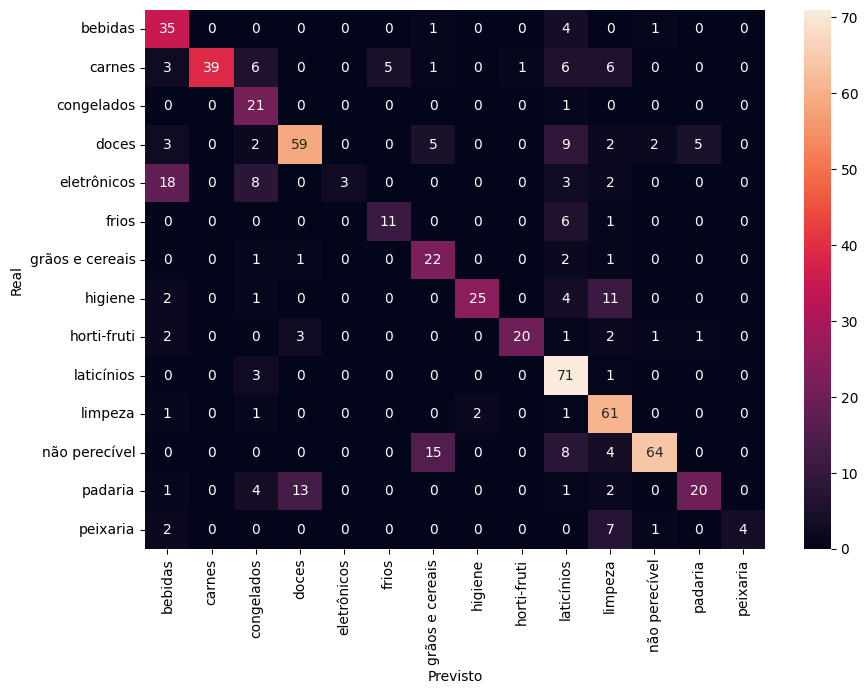

                 precision    recall  f1-score   support

        bebidas       0.52      0.85      0.65        41
         carnes       1.00      0.58      0.74        67
     congelados       0.45      0.95      0.61        22
          doces       0.78      0.68      0.72        87
    eletrônicos       1.00      0.09      0.16        34
          frios       0.69      0.61      0.65        18
grãos e cereais       0.50      0.81      0.62        27
        higiene       0.93      0.58      0.71        43
    horti-fruti       0.95      0.67      0.78        30
     laticínios       0.61      0.95      0.74        75
        limpeza       0.61      0.92      0.73        66
  não perecível       0.93      0.70      0.80        91
        padaria       0.77      0.49      0.60        41
       peixaria       1.00      0.29      0.44        14

       accuracy                           0.69       656
      macro avg       0.77      0.66      0.64       656
   weighted avg       0.78   

In [61]:
# Testa modelo final.
evaluate_predictions(model, tokenizer, validation_products)

In [62]:
# Atualiza modelo atual.
training_model = get_last_trained_model_name(results_path, base_model)
log(f"Saved model: {training_model}", blue_color)

Saved model: checkpoint-20


# Save checkpoint

In [ ]:
# Salva o modelo no drive.
if (__SHOULD_SAVE__):
  copy_folder_to_drive(training_model)